In [ ]:
# Ridge Regression 
# better when many predictors 
# coefficient about same size 


# Choice 1: Add shooter-talent to xG Model as a Variable 

# Recall, 
# Ratio bewteen   Actual Goal : xG     called   Shot Ratio  
# Fitted into a Gamma Distribution and compute the posterior mean using Bayesian Stats 
# Calculate shooter's talent by posterior shot ratio / league average shot ratio 

# Code Index: 
# Block 1: Combine Shooter's Talent as a column with the xgmodel data 
# Block 2: Run the Logistic Regression 
# Block 3: 
# Compute actual probability for each event 

# Block 4:
# Compute xG for each game 

# Block 5: 
# Team Level Analysis 
# 1. Calculate a team's GF%, xGF%, dGF% 
# 2. Graph xG% vs. GF%  
# 3. Calculate team's xGF, xGA per Game  
# 4. xGF per Game vs. xGA per game analysis 
# 5. Team's Actual GF, GA 

# Block 6: 
# Individual Player Analysis 
# 1. Calculate each player’s xG 
# 2. Graph xG and G by Player
# 3. xG by on ice position graph 
# 4. Graph each player's shot location on ice 

In [ ]:
# Model Evaluations: 
# AUC: 0.77 
# Log Loss: 0.21 
# Degrees of Freedom: 31
# p-value (Wilks' Theorm): 0.000000000000001
# Deviance (Full Model): 24978.27689228754.     
# AIC (Full Model): 25040.27689228754.         Slightly better than previous model 

# Likelihood Ratio Test from Previous Model 
# -2 (54912) + 2 (55509) - chisq df=1 
# P-Value = 1- pchisq(1194, df=1) 
# = 0       
# This one is better than the previous one 

# Variable Significance Level:  (only 4 are significant)  (Wald's Test) 
#              Feature                   Wald_stat                 p_value
#            ShotDistance      [[1629.2498643723284]]                     0.0
#               ShotAngle       [[392.8076317530689]]  2.0260864714359143e-87
#          shooterstalent      [[317.92649573851855]]    4.09788608779898e-71
#              is_rebound       [[49.09860057113725]]  2.4341381014251717e-12

# Summary Statistics for xG Probability (Before) 
# count    113331.000000
# mean          0.068309
# std           0.062541
# min           0.000003
# 25%           0.022584
# 50%           0.050223
# 75%           0.093440
# max           0.562873

# Summary Statistics for xG Probability (After) 
# count    113331.000000
# mean          0.067408
# std           0.064610
# min           0.000002
# 25%           0.021012
# 50%           0.047887
# 75%           0.092137
# max           0.619348

In [144]:
# Block 1: 

import pandas as pd
import numpy as np
import math

# Read the xgmodel CSV (the xG model data)
df_xgmodel = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/xgmodel.csv')

# Read the updated players CSV that now contains the shooter talent column (playersshoot.csv)
df_playersshoot = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/playersshoot.csv')

# Merge the xgmodel data with the players data
# Match xgmodel's 'Player1' with players' 'playerId'
df_xgmodels = pd.merge(
    df_xgmodel,
    df_playersshoot[['playerId', 'shootershoot']],
    left_on='Player1',
    right_on='playerId',
    how='left'
)

# Create the new column "shooterstalent":
# If no match was found (i.e. NaN), fill with 1.
df_xgmodels['shooterstalent'] = df_xgmodels['shootershoot'].fillna(1)

df_xgmodels.drop(columns=['playerId_y', 'shootershoot'], inplace=True)

# Optionally, drop the extra merge key columns if not needed

# Save the merged data as a new CSV file called "xgmodels.csv"
df_xgmodels.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xgmodel4s.csv', index=False)

In [1]:
# Block 2
# Logistic Regression 

import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import log_loss 

In [2]:
df = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xgmodel4s.csv')
print(df.columns) 
df

Index(['EventID', 'EventTeam', 'ShotDistance', 'ShotAngle', 'X', 'Y',
       'StrengthState', 'ScoreState', 'LastEvent', 'shotType', 'Player1',
       'Event', 'TSLE', 'is_rebound', 'Goal', 'Goalie', 'playerId_x',
       'Position', 'is_forward', 'shooterstalent'],
      dtype='object')


,EventID,EventTeam,ShotDistance,ShotAngle,X,Y,StrengthState,ScoreState,LastEvent,shotType,Player1,Event,TSLE,is_rebound,Goal,Goalie,playerId_x,Position,is_forward,shooterstalent
0,20240200010001,NJD,51.224994,51.340192,57.0,-40.0,EV1,0,Other,wrist,8483495,shot-on-goal,0.0,0,0,8480045.0,8483495,D,0,1.000000
1,20240200010002,NJD,33.286634,57.264774,71.0,-28.0,EV1,0,No,wrist,8479407,missed-shot,21.0,0,0,8480045.0,8479407,F,1,0.910679
2,20240200010003,NJD,47.507894,30.343249,48.0,-24.0,EV1,0,No,slap,8476462,shot-on-goal,11.0,0,0,8480045.0,8476462,D,0,0.963726
3,20240200010004,BUF,57.140179,32.855722,41.0,31.0,EV1,0,No,wrist,8482175,shot-on-goal,22.0,0,0,8474593.0,8482175,F,1,1.237882
4,20240200010005,BUF,55.081757,15.802514,36.0,-15.0,EV1,0,Other,slap,8482671,missed-shot,4.0,0,0,8474593.0,8482671,D,0,0.882076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113326,20240301810084,EDM,13.892444,59.743563,82.0,-12.0,PP1,-1,No,wrist,8478402,goal,26.0,0,1,8475311.0,8478402,F,1,0.956759
113327,20240301810085,EDM,38.078866,29.931512,56.0,19.0,EV1,0,No,snap,8478042,shot-on-goal,15.0,0,0,8475311.0,8478042,F,1,0.873830
113328,20240301810086,EDM,30.413813,27.407575,62.0,14.0,EV1,0,No,snap,8477934,shot-on-goal,17.0,0,0,8475311.0,8477934,F,1,1.441500
113329,20240301810087,LAK,36.496575,9.462322,53.0,6.0,EV1,0,No,wrist,8476479,goal,14.0,0,1,8479973.0,8476479,F,1,0.813817


In [3]:
y = df["Goal"] 
y

0         0
1         0
2         0
3         0
4         0
         ..
113326    1
113327    0
113328    0
113329    1
113330    0
Name: Goal, Length: 113331, dtype: int64

In [4]:
X1 = df[["StrengthState","ScoreState", "LastEvent", "shotType", 'is_forward','is_rebound']]
X1

,StrengthState,ScoreState,LastEvent,shotType,is_forward,is_rebound
0,EV1,0,Other,wrist,0,0
1,EV1,0,No,wrist,1,0
2,EV1,0,No,slap,0,0
3,EV1,0,No,wrist,1,0
4,EV1,0,Other,slap,0,0
...,...,...,...,...,...,...
113326,PP1,-1,No,wrist,1,0
113327,EV1,0,No,snap,1,0
113328,EV1,0,No,snap,1,0
113329,EV1,0,No,wrist,1,0


In [5]:
X2 = df[["ShotDistance","ShotAngle","shooterstalent"]] 
X2

,ShotDistance,ShotAngle,shooterstalent
0,51.224994,51.340192,1.000000
1,33.286634,57.264774,0.910679
2,47.507894,30.343249,0.963726
3,57.140179,32.855722,1.237882
4,55.081757,15.802514,0.882076
...,...,...,...
113326,13.892444,59.743563,0.956759
113327,38.078866,29.931512,0.873830
113328,30.413813,27.407575,1.441500
113329,36.496575,9.462322,0.813817


In [6]:
X1 = pd.get_dummies(X1) 
X1 = X1.astype(int) 
X1

,is_forward,is_rebound,StrengthState_EV1,StrengthState_EV2,StrengthState_PP1,StrengthState_PP2,StrengthState_SH,ScoreState_-1,ScoreState_-2,ScoreState_0,...,shotType_bat,shotType_between-legs,shotType_cradle,shotType_deflected,shotType_poke,shotType_slap,shotType_snap,shotType_tip-in,shotType_wrap-around,shotType_wrist
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113326,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
113327,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
113328,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
113329,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [7]:
X = X2.join(X1) 
X 

,ShotDistance,ShotAngle,shooterstalent,is_forward,is_rebound,StrengthState_EV1,StrengthState_EV2,StrengthState_PP1,StrengthState_PP2,StrengthState_SH,...,shotType_bat,shotType_between-legs,shotType_cradle,shotType_deflected,shotType_poke,shotType_slap,shotType_snap,shotType_tip-in,shotType_wrap-around,shotType_wrist
0,51.224994,51.340192,1.000000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,33.286634,57.264774,0.910679,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,47.507894,30.343249,0.963726,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,57.140179,32.855722,1.237882,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,55.081757,15.802514,0.882076,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113326,13.892444,59.743563,0.956759,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
113327,38.078866,29.931512,0.873830,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
113328,30.413813,27.407575,1.441500,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
113329,36.496575,9.462322,0.813817,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3) 

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    penalty='l2',        # Use L2 regularization (ridge)
    max_iter=6000,       # Maximum number of iterations for convergence
    fit_intercept=False, 
    solver = 'saga'  
).fit(X_train, y_train) 

# # a logistic regression two parameters:
# max_iter: max number of iterations the solver will use to converge        
# fit_intercept=False: This tells the model not to calculate an intercept term                    
# log_reg = LogisticRegression(max_iter=6000, fit_intercept=False).fit(X_train, y_train)  

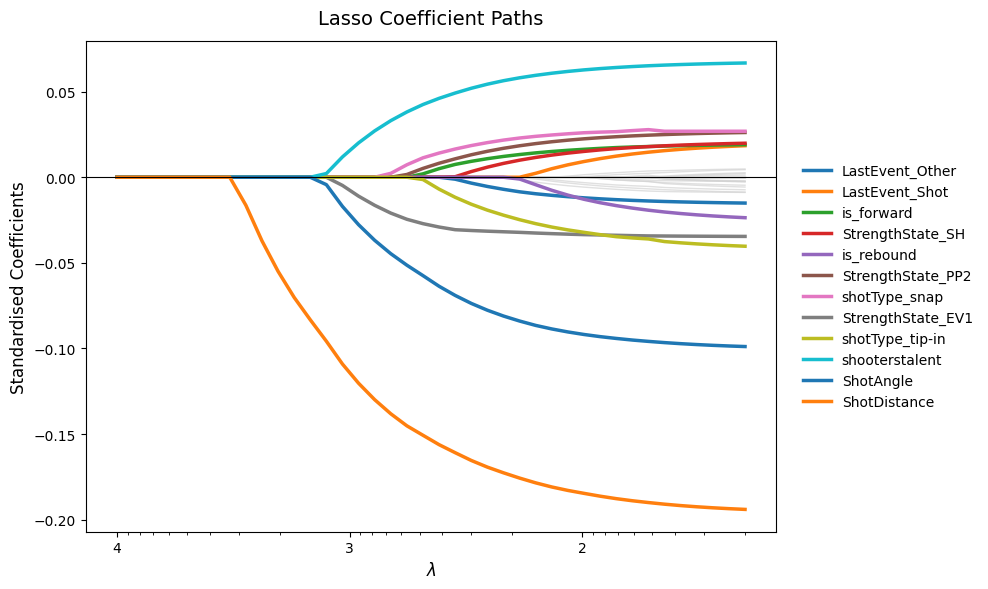

In [10]:
# ------------------------------------------------------------
#  Lasso coefficient path (logistic regression, saga solver)
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterExponent
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -----------------------------------------------------------------
# STEP 0 •  Your data  -------------------------------------------
# -----------------------------------------------------------------
#  X_train : pandas DataFrame  (n_samples × p)
#  y_train : array‑like target (binary 0/1 or bool/int)
#  If you already have them in memory, comment out these example lines.
#
# X_train = pd.read_csv("X_train.csv", index_col=0)
# y_train = pd.read_csv("y_train.csv", squeeze=True)

feature_names = X_train.columns.to_numpy()   # keep feature labels

# -----------------------------------------------------------------
# STEP 1 •  Standardise predictors
# -----------------------------------------------------------------
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# -----------------------------------------------------------------
# STEP 2 •  Grid of λ values  (big → small)
# -----------------------------------------------------------------
lambdas = np.logspace(4.0, 1.3, 40)   # 10000  …  20   (40 points)
Cs      = 1.0 / lambdas               # scikit‑learn uses C = 1/λ

coefs = []                            # will collect shape (len(Cs), p)

for C in Cs:
    clf = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=C,
        max_iter=6000,
        fit_intercept=False,
        tol=1e-4,
        random_state=0
    ).fit(X_scaled, y_train)

    coefs.append(clf.coef_.ravel())

coefs = np.vstack(coefs)  # numpy array (n_lambda × p)

# -----------------------------------------------------------------
# STEP 3 •  Plot helper function
# -----------------------------------------------------------------
def lasso_path_plot(lambdas, coefs, feature_names, top_k=12):
    """
    lambdas      : 1‑D array of λ values (descending order)
    coefs        : 2‑D array, shape (n_lambda, p)
    feature_names: list or 1‑D array of length p
    top_k        : highlight this many strongest coefficients
    """
    lambdas = np.asarray(lambdas)
    coefs   = np.asarray(coefs)

    # ----- decide which features to emphasise ------------------
    max_abs   = np.max(np.abs(coefs), axis=0)        # peak magnitude
    emphasise = np.argsort(max_abs)[-top_k:]         # indices to highlight
    other     = np.setdiff1d(np.arange(coefs.shape[1]), emphasise)

    # ----- plot ------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # faint grey for the rest
    for j in other:
        ax.plot(lambdas, coefs[:, j],
                color='lightgrey', linewidth=1, alpha=0.7)

    # coloured lines for emphasised curves
    for j in emphasise:
        ax.plot(lambdas, coefs[:, j],
                linewidth=2.5,
                label=feature_names[j])

    ax.set_xscale('log')
    ax.invert_xaxis()                     # large λ on the left
    ax.axhline(0, color='black', linewidth=0.8)

    ax.set_xlabel(r'$\lambda$', fontsize=12)
    ax.set_ylabel('Standardised Coefficients', fontsize=12)
    ax.set_title('Lasso Coefficient Paths', fontsize=14, pad=12)

    ax.yaxis.set_tick_params(labelsize=10)
    ax.xaxis.set_major_formatter(LogFormatterExponent(base=10))

    # legend outside
    ax.legend(loc='center left',
              bbox_to_anchor=(1.02, 0.5),
              frameon=False, fontsize=10)

    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------
# STEP 4 •  Draw the plot
# -----------------------------------------------------------------
lasso_path_plot(lambdas, coefs, feature_names, top_k=12)


In [154]:
# Predict probabilities on the training set (column [:,1] is the probability of class "1")
prob = log_reg.predict_proba(X_test)[:, 1]
y_test = y_test.tolist()  # Convert y_test to a Python list

In [155]:
# (Likewise) predict probabilities on the training set, store them in 'prob_train'
prob_train = log_reg.predict_proba(X_train)[:, 1]
y_train = y_train.tolist()  # Convert y_train to a Python list 

In [156]:
# Create a DataFrame to store probabilities and actual goals
test = pd.DataFrame()
test['prob'] = pd.DataFrame(prob.tolist())  # or prob.tolist() if you prefer
test['Goal'] = pd.DataFrame(y_test)
test 

,prob,Goal
0,0.024583,0
1,0.029146,0
2,0.038309,0
3,0.011007,0
4,0.226240,0
...,...,...
33995,0.037467,0
33996,0.015568,0
33997,0.031863,0
33998,0.080694,0


In [157]:
test2 = pd.DataFrame() 
test2['prob'] = pd.DataFrame(prob_train.tolist())
test2['Goal'] = pd.DataFrame(y_train) 
test2 

,prob,Goal
0,0.008419,0
1,0.105825,0
2,0.149722,0
3,0.072883,0
4,0.006992,0
...,...,...
79326,0.069338,0
79327,0.061124,0
79328,0.063608,0
79329,0.193124,0


In [158]:
# Area Under Curve 
# Receiver operating characteristic
# the sensitivity as a function of false positive rate. (Type I Error) 

# it means that 76% of the time, the model will assign a higher probability to a positive example than to a negative one 

AUC = roc_auc_score(y_test, prob) 
AUC 

np.float64(0.7756754810174976)

In [159]:
AUC2 = roc_auc_score(y_train, prob_train) 
AUC2 

np.float64(0.7653176601443568)

In [160]:
# Calculate log loss on the first set 
# how close the predicted probabilities are to the true class labels 
# A smaller log loss value indicates that the predicted probabilities are close to the actual outcomes 

logloss = log_loss(
    y_true=test['Goal'],
    y_pred=test['prob'],
    sample_weight=None,
    normalize=True
)
logloss 

0.216131339309507

In [161]:
# Calculate log loss on a second set
logloss2 = log_loss(
    y_true=test2['Goal'],
    y_pred=test2['prob'],
    sample_weight=None,
    normalize=True
)
logloss2 

0.21759171249512266

In [162]:
# Examine the model coefficients
coef = pd.DataFrame(
    zip(X_train.columns, np.transpose(log_reg.coef_)),
    columns=['features', 'coef']
)
coef     

,features,coef
0,ShotDistance,[-0.06368765773220988]
1,ShotAngle,[-0.016112508401567995]
2,shooterstalent,[1.9038614349569898]
3,is_forward,[-0.0752330339683871]
4,is_rebound,[-0.5738517312055791]
5,StrengthState_EV1,[-0.9045252970396833]
6,StrengthState_EV2,[-0.6779317983587828]
7,StrengthState_PP1,[-0.6254976800708657]
8,StrengthState_PP2,[-0.060436154444421956]
9,StrengthState_SH,[-0.5987658819158636]


In [163]:
# Store Regression Coefficient Data 

coef = pd.DataFrame(
    zip(X_train.columns, np.transpose(log_reg.coef_)),
    columns=['features', 'coef']
)

# Convert each coefficient (which is an array) to a scalar value.
coef['coef'] = coef['coef'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)

# convert the coefficient to a string 
coef['coef'] = coef['coef'].astype(str)
coef 

# Save to CSV without index
coef.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xgcoef2.csv', sep=',', encoding='utf-8', index=False, header=True) 

In [164]:
# Summary Stats for probability xG 
print(test['prob'].describe()) 


count    34000.000000
mean         0.067496
std          0.065098
min          0.000002
25%          0.020831
50%          0.047562
75%          0.092262
max          0.611696
Name: prob, dtype: float64


In [165]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2

# 5) Compute log-likelihood of the full model on the training set
#    Get predicted probabilities for the positive class
p_train = log_reg.predict_proba(X_train)[:, 1]
y_train_np = np.array(y_train, dtype=float)  # ensure it's a numeric array

loglik_full = np.sum(
    y_train_np * np.log(p_train) +
    (1 - y_train_np) * np.log(1 - p_train)
)

# 6) Compute log-likelihood of the null model (no predictors => p=0.5)
n = len(y_train_np)
loglik_null = n * np.log(0.5)

# 7) Likelihood Ratio (LR) statistic and p-value (Wilks' Test)
LR_stat = 2 * (loglik_full - loglik_null)
df_lr = X_train.shape[1]  # Number of parameters (features); null model has 0 parameters
p_value = 1 - chi2.cdf(LR_stat, df_lr)

# 8) Compute Deviance and AIC
# Deviance: D = -2 * log-likelihood (full model)
deviance_full = -2 * loglik_full
# AIC:  AIC = 2*k - 2 * loglik_full, where k = number of parameters
k = X_train.shape[1]
AIC = 2 * k - 2 * loglik_full

# 9) Print all results
print("Full Model Log-Likelihood:", loglik_full)
print("Null Model Log-Likelihood:", loglik_null)
print("Likelihood Ratio (LR) Statistic:", LR_stat)
print("Degrees of Freedom:", df_lr)
print("p-value (Wilks' Test):", p_value)
print("Deviance (Full Model):", deviance_full)
print("AIC (Full Model):", AIC) 

Full Model Log-Likelihood: -17261.768143950576
Null Model Log-Likelihood: -54988.05898100102
Likelihood Ratio (LR) Statistic: 75452.58167410089
Degrees of Freedom: 31
p-value (Wilks' Test): 0.0
Deviance (Full Model): 34523.53628790115
AIC (Full Model): 34585.53628790115


In [166]:
# Wald's Test for each variable 

import statsmodels.api as sm
import pandas as pd

# 1) Fit your logistic regression with statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# 2) Loop through each column in X_train, run a Wald test, and collect results
wald_results = []
for col in X_train.columns:
    hypothesis = f"{col} = 0"
    test_result = result.wald_test(hypothesis)
    # Extract p-value and Wald statistic; the p-value is a float value.
    p_value = test_result.pvalue
    wald_stat = test_result.statistic
    wald_results.append({'Feature': col, 'Wald_stat': wald_stat, 'p_value': p_value})

# 3) Create a DataFrame from the results and sort by p-value (lowest first)
wald_df = pd.DataFrame(wald_results)
wald_df_sorted = wald_df.sort_values(by='p_value').reset_index(drop=True)

print("Ranking of variables from most to least important (lowest p-value indicates higher importance):")
print(wald_df_sorted)


         Current function value: 0.217229
         Iterations: 35
Ranking of variables from most to least important (lowest p-value indicates higher importance):
                  Feature                   Wald_stat                 p_value
0            ShotDistance      [[2286.9717543096945]]                     0.0
1               ShotAngle       [[573.7277926178855]]  8.678130843135775e-127
2          shooterstalent      [[370.97051719780916]]  1.1504908478291272e-82
3              is_rebound       [[66.54188593651332]]   3.425371553117877e-16
4              is_forward      [[2.5315627233263305]]     0.11158965255689851
5         shotType_cradle    [[0.000414039911269084]]        0.98376578861775
6   shotType_between-legs  [[0.00022359049405161775]]      0.9880697225012242
7    shotType_wrap-around     [[0.00019222910568885]]      0.9889379473697848
8         shotType_tip-in  [[0.00019177515519198436]]      0.9889510158149806
9      shotType_deflected  [[0.00018654921823944693]]     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [167]:
# Wald Test for overall model 

import numpy as np
import statsmodels.api as sm

# 1) Fit your logistic regression model in statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# 2) Construct a matrix R for the joint hypothesis test:
#    "All coefficients = 0".
k = len(X_train.columns)
R = np.eye(k)

# 3) Perform the joint Wald test
joint_test_result = result.wald_test(R)

print("Joint Wald Test for All Coefficients = 0:")
print(joint_test_result)

         Current function value: 0.217229
         Iterations: 35
Joint Wald Test for All Coefficients = 0:
<Wald test (chi2): statistic=[[6.19263982]], p-value=0.18521630505166436, df_denom=4>


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 31, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


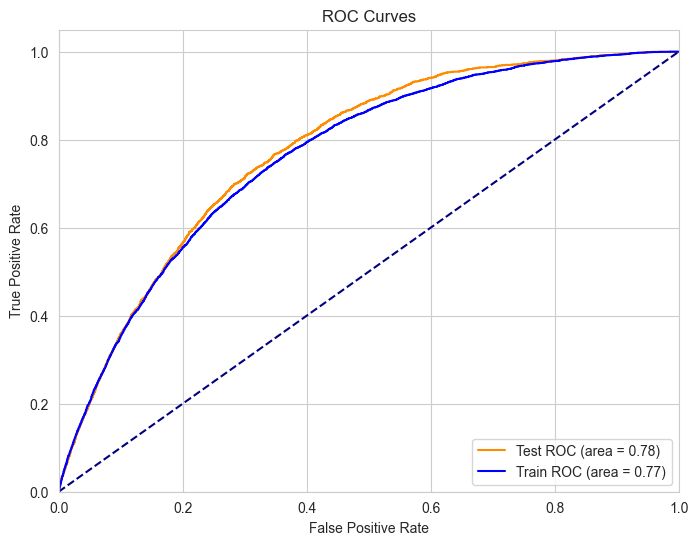

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# 1. ROC Curves for Train and Test
fpr_test, tpr_test, _ = roc_curve(test['Goal'], test['prob'])
roc_auc_test = auc(fpr_test, tpr_test)

fpr_train, tpr_train, _ = roc_curve(test2['Goal'], test2['prob'])
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange',
         label='Test ROC (area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='blue',
         label='Train ROC (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# All the AIC, Deviance 

# Wald's Test how signifiocant each varibale is 

Confusion Matrix (Test):
 [[25402  6300]
 [ 1004  1294]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     31702
           1       0.17      0.56      0.26      2298

    accuracy                           0.79     34000
   macro avg       0.57      0.68      0.57     34000
weighted avg       0.91      0.79      0.83     34000


Confusion Matrix (Train):
 [[59288 14701]
 [ 2392  2950]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     73989
           1       0.17      0.55      0.26      5342

    accuracy                           0.78     79331
   macro avg       0.56      0.68      0.57     79331
weighted avg       0.91      0.78      0.83     79331



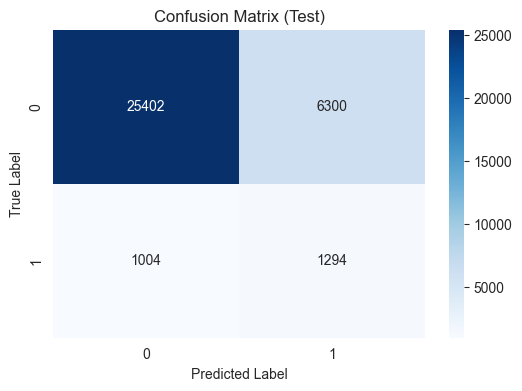

In [169]:
# 2. Confusion Matrix & Classification Report
# Choose a predicted probability 
threshold = 0.1

# Test set
y_pred_test = (test['prob'] >= threshold).astype(int)
cm_test = confusion_matrix(test['Goal'], y_pred_test)
print("Confusion Matrix (Test):\n", cm_test)
print("\nClassification Report (Test):")
print(classification_report(test['Goal'], y_pred_test))

# Train set
y_pred_train = (test2['prob'] >= threshold).astype(int)
cm_train = confusion_matrix(test2['Goal'], y_pred_train)
print("\nConfusion Matrix (Train):\n", cm_train)
print("\nClassification Report (Train):")
print(classification_report(test2['Goal'], y_pred_train))

# plot a heatmap for the test confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

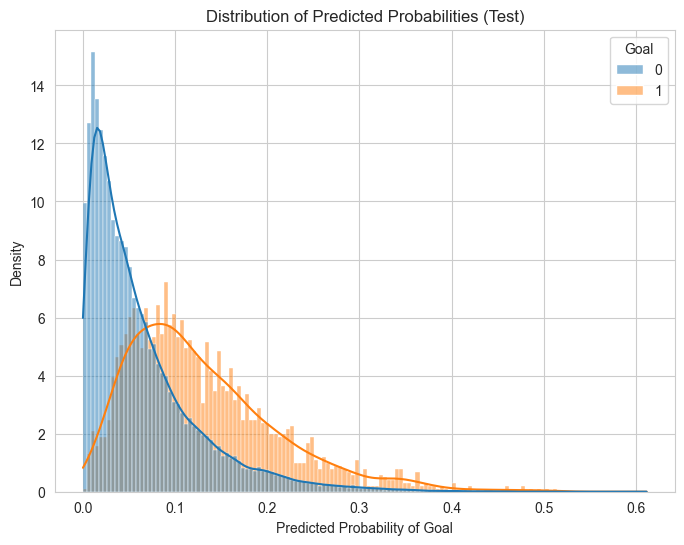

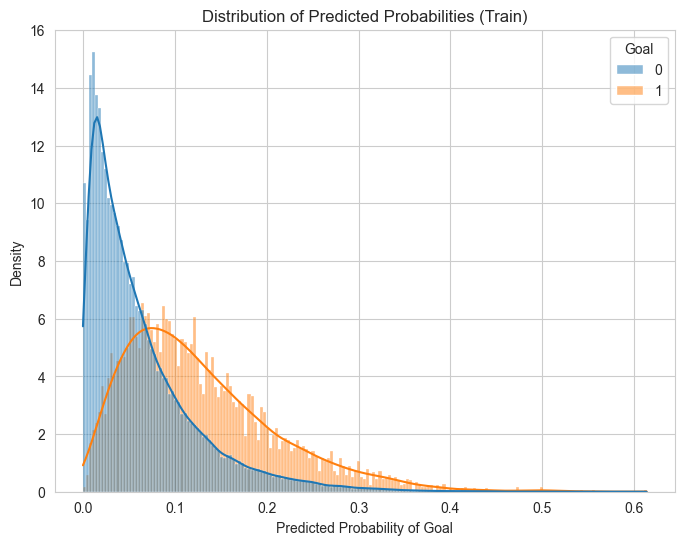

In [170]:
# 3. Distribution of Predicted Probabilities
# Compare distributions for "Goal=1" vs. "Goal=0" in test set
plt.figure(figsize=(8, 6))
sns.histplot(data=test, x='prob', hue='Goal', kde=True, stat='density', common_norm=False)
plt.title('Distribution of Predicted Probabilities (Test)')
plt.xlabel('Predicted Probability of Goal')
plt.ylabel('Density')
plt.show()

# training set if desired:
plt.figure(figsize=(8, 6))
sns.histplot(data=test2, x='prob', hue='Goal', kde=True, stat='density', common_norm=False)
plt.title('Distribution of Predicted Probabilities (Train)')
plt.xlabel('Predicted Probability of Goal')
plt.ylabel('Density')
plt.show()

In [171]:
print(coef.keys())


Index(['features', 'coef'], dtype='object')


In [172]:
# Compute actual probability for each event 

import pandas as pd
import numpy as np

xg_model_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xgmodel4s.csv'
xg_coef_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xgcoef2.csv'

df_xg_model = pd.read_csv(xg_model_fp)    
df_xg_coef  = pd.read_csv(xg_coef_fp)    # Expected columns: ['features', 'coef']

# Convert the "features" & "coef" columns into a dictionary
coef_dict = df_xg_coef.set_index('features')['coef'].to_dict()

# 2. Create a Working Copy and Compute Weighted Values
df_xG_temp1 = df_xg_model.copy()

# (a) Weighted Continuous Features (do not overwrite the original ShotDistance & ShotAngle)
df_xG_temp1['WeightedShotDistance'] = df_xG_temp1['ShotDistance'] * coef_dict['ShotDistance']
df_xG_temp1['WeightedShotAngle']    = df_xG_temp1['ShotAngle']    * coef_dict['ShotAngle']
df_xG_temp1['WeightedShooterTalent'] = df_xG_temp1['shooterstalent'] * coef_dict['shooterstalent']

# (b) Map StrengthState to its coefficient; store result in WeightedStrengthState.
strength_conditions = [
    df_xG_temp1['StrengthState'] == 'EV1',
    df_xG_temp1['StrengthState'] == 'EV2',
    df_xG_temp1['StrengthState'] == 'PP1',
    df_xG_temp1['StrengthState'] == 'PP2',
    df_xG_temp1['StrengthState'] == 'SH'
]
strength_choices = [
    coef_dict['StrengthState_EV1'],
    coef_dict['StrengthState_EV2'],
    coef_dict['StrengthState_PP1'],
    coef_dict['StrengthState_PP2'],
    coef_dict['StrengthState_SH']
]
df_xG_temp1['WeightedStrengthState'] = np.select(strength_conditions, strength_choices, default=0)

# (c) Map ScoreState to its coefficient; store in WeightedScoreState.
score_conditions = [
    df_xG_temp1['ScoreState'] == '-1',
    df_xG_temp1['ScoreState'] == '-2',
    df_xG_temp1['ScoreState'] == '0',
    df_xG_temp1['ScoreState'] == '1',
    df_xG_temp1['ScoreState'] == '2',
    df_xG_temp1['ScoreState'] == '<-2',
    df_xG_temp1['ScoreState'] == '>2'
]
score_choices = [
    coef_dict['ScoreState_-1'],
    coef_dict['ScoreState_-2'],
    coef_dict['ScoreState_0'],
    coef_dict['ScoreState_1'],
    coef_dict['ScoreState_2'],
    coef_dict['ScoreState_<-2'],
    coef_dict['ScoreState_>2']
]
df_xG_temp1['WeightedScoreState'] = np.select(score_conditions, score_choices, default=0)

# (d) Map LastEvent to its coefficient; store in WeightedLastEvent.
le_conditions = [
    df_xG_temp1['LastEvent'] == 'No',
    df_xG_temp1['LastEvent'] == 'Shot',
    df_xG_temp1['LastEvent'] == 'Other'
]
le_choices = [
    coef_dict['LastEvent_No'],
    coef_dict['LastEvent_Shot'],
    coef_dict['LastEvent_Other']
]
df_xG_temp1['WeightedLastEvent'] = np.select(le_conditions, le_choices, default=0)

# (e) Map shotType to its coefficient; store in WeightedShotType.
st_conditions = [
    df_xG_temp1['shotType'] == 'bat',
    df_xG_temp1['shotType'] == 'between-legs',
    df_xG_temp1['shotType'] == 'cradle',
    df_xG_temp1['shotType'] == 'poke',
    df_xG_temp1['shotType'] == 'slap',
    df_xG_temp1['shotType'] == 'backhand',
    df_xG_temp1['shotType'] == 'deflected',
    df_xG_temp1['shotType'] == 'snap',
    df_xG_temp1['shotType'] == 'tip-in',
    df_xG_temp1['shotType'] == 'wrap-around',
    df_xG_temp1['shotType'] == 'wrist'
]
st_choices = [
    coef_dict['shotType_bat'],
    coef_dict['shotType_between-legs'],
    coef_dict['shotType_cradle'],
    coef_dict['shotType_poke'],
    coef_dict['shotType_slap'],
    coef_dict['shotType_backhand'],
    coef_dict['shotType_deflected'],
    coef_dict['shotType_snap'],
    coef_dict['shotType_tip-in'],
    coef_dict['shotType_wrap-around'],
    coef_dict['shotType_wrist']
]
df_xG_temp1['WeightedShotType'] = np.select(st_conditions, st_choices, default=0)

# (f) is_forward 
df_xG_temp1['WeightedIsForward'] = df_xG_temp1['is_forward'] * coef_dict['is_forward'] 

# (g) is_rebound 
df_xG_temp1['WeightedIsRebound'] = df_xG_temp1['is_rebound'] * coef_dict['is_rebound']


# 3. Compute xG Using the Logistic Function
# z = (WeightedShotDistance + WeightedShotAngle + WeightedStrengthState + 
#      WeightedScoreState + WeightedLastEvent + WeightedShotType + WeightedIsForward)

# xG = 1 / (1 + e^(-z))

sum_vars = (df_xG_temp1['WeightedShotDistance'] + 
            df_xG_temp1['WeightedShotAngle'] +
            df_xG_temp1['WeightedStrengthState'] +
            df_xG_temp1['WeightedScoreState'] +
            df_xG_temp1['WeightedLastEvent'] +
            df_xG_temp1['WeightedShotType'] +
            df_xG_temp1['WeightedIsForward']+
            df_xG_temp1['WeightedShooterTalent']+ 
            df_xG_temp1['WeightedIsRebound']
           )

df_xG_temp1['xG'] = 1 / (1 + np.exp(-sum_vars))

# 4. Export the Result
print(df_xG_temp1[['EventID', 'EventTeam', 'Player1', 'ShotDistance', 'ShotAngle', 
                     'StrengthState', 'ScoreState', 'LastEvent', 'shotType', 'is_forward', 'shooterstalent','xG']].head())

# Export the full DataFrame to CSV
output_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xg_results.csv'
df_xG_temp1.to_csv(output_fp, index=False)
print("Export complete: xg_results.csv has been saved.")


          EventID EventTeam  Player1  ShotDistance  ShotAngle StrengthState  \
0  20240200010001       NJD  8483495     51.224994  51.340192           EV1   
1  20240200010002       NJD  8479407     33.286634  57.264774           EV1   
2  20240200010003       NJD  8476462     47.507894  30.343249           EV1   
3  20240200010004       BUF  8482175     57.140179  32.855722           EV1   
4  20240200010005       BUF  8482671     55.081757  15.802514           EV1   

  ScoreState LastEvent shotType  is_forward  shooterstalent        xG  
0          0     Other    wrist           0        1.000000  0.008474  
1          0        No    wrist           1        0.910679  0.028371  
2          0        No     slap           0        0.963726  0.031978  
3          0        No    wrist           1        1.237882  0.017352  
4          0     Other     slap           0        0.882076  0.014193  
Export complete: xg_results.csv has been saved.


In [174]:
print("\nSummary Statistics for xG Probability:")
print(df_xG_temp1['xG'].describe()) 

df_xG_temp1 = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xg_results.csv')
print(df_xG_temp1.columns)  


Summary Statistics for xG Probability:
count    113331.000000
mean          0.067409
std           0.064914
min           0.000002
25%           0.020765
50%           0.047588
75%           0.092280
max           0.613481
Name: xG, dtype: float64
Index(['EventID', 'EventTeam', 'ShotDistance', 'ShotAngle', 'X', 'Y',
       'StrengthState', 'ScoreState', 'LastEvent', 'shotType', 'Player1',
       'Event', 'TSLE', 'is_rebound', 'Goal', 'Goalie', 'playerId_x',
       'Position', 'is_forward', 'shooterstalent', 'WeightedShotDistance',
       'WeightedShotAngle', 'WeightedShooterTalent', 'WeightedStrengthState',
       'WeightedScoreState', 'WeightedLastEvent', 'WeightedShotType',
       'WeightedIsForward', 'WeightedIsRebound', 'xG'],
      dtype='object')


In [1]:
# Compute xG for each game 

import pandas as pd
import numpy as np

# Step 1: Load Event-Level xG Predictions and Extract GameID
df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xg_results.csv')
# Extract GameID from EventID (assuming EventID = GameID*10000 + row_number)
df_xg['GameID'] = df_xg['EventID'] // 10000

# Step 2: Load Play-by-Play Data to Get the Shooting Team
# pbp_adjusted.csv has columns including EventID and EventTeam.
df_pbp = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/pbp_adjusted.csv')
df_events = pd.merge(df_xg, df_pbp[['EventID', 'EventTeam']], on='EventID', how='left')

# Step 3: Aggregate xG by Game and Team
# Group by GameID and EventTeam to get total expected goals (Team_xG) for each team.
df_team_xg = (df_xg
    .groupby(['GameID', 'EventTeam'], as_index=False)['xG']
    .sum()
    .rename(columns={'xG': 'Team_xG'})
)

# Step 4: Load and Prepare Schedule Data
df_schedule = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/schedule.csv')

# Rename schedule columns to avoid conflicts
df_schedule.rename(columns={
    'Team': 'SchedTeam',
    'Opponent': 'SchedOpponent',
    'Venue': 'SchedVenue'
}, inplace=True)

# Derive HomeTeam and AwayTeam based on scheduled venue:
df_schedule['HomeTeam'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                   df_schedule['SchedTeam'],
                                   df_schedule['SchedOpponent'])
df_schedule['AwayTeam'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                   df_schedule['SchedOpponent'],
                                   df_schedule['SchedTeam'])

# Derive actual scores (if applicable)
df_schedule['HomeScore'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                    df_schedule['GF'],
                                    df_schedule['GA'])
df_schedule['AwayScore'] = np.where(df_schedule['SchedVenue'] == 'Home',
                                    df_schedule['GA'],
                                    df_schedule['GF'])

# Convert GameDate to datetime.date for proper sorting
df_schedule['gameDate'] = pd.to_datetime(df_schedule['GameDate']).dt.date

# Drop duplicate rows by GameID if any exist
df_schedule.drop_duplicates(subset=['GameID'], inplace=True)

# Step 5: Merge Aggregated xG with Schedule Data for Home and Away Teams Separately
# Merge home team xG: match schedule HomeTeam with EventTeam in df_team_xg.
df_home = pd.merge(df_schedule[['GameID', 'HomeTeam']], df_team_xg,
                   left_on=['GameID', 'HomeTeam'],
                   right_on=['GameID', 'EventTeam'],
                   how='left')
df_home.rename(columns={'Team_xG': 'Home_xG'}, inplace=True)
df_home = df_home[['GameID', 'Home_xG']]

# Merge away team xG: match schedule AwayTeam with EventTeam.
df_away = pd.merge(df_schedule[['GameID', 'AwayTeam']], df_team_xg,
                   left_on=['GameID', 'AwayTeam'],
                   right_on=['GameID', 'EventTeam'],
                   how='left')
df_away.rename(columns={'Team_xG': 'Away_xG'}, inplace=True)
df_away = df_away[['GameID', 'Away_xG']]

# Merge the home and away xG values into schedule
df_final = pd.merge(df_schedule, df_home, on='GameID', how='left')
df_final = pd.merge(df_final, df_away, on='GameID', how='left')

# Replace missing xG with 0 (if no xG events were recorded for that team in a game)
df_final['Home_xG'] = df_final['Home_xG'].fillna(0)
df_final['Away_xG'] = df_final['Away_xG'].fillna(0)

# Step 6: Sort Final Data by gameDate (Earliest Game First) and Print Summary Stats
df_final.sort_values(by='gameDate', inplace=True)

print("Summary of Total xG for Home Teams:")
print(df_final['Home_xG'].describe())

print("\nSummary of Total xG for Away Teams:")
print(df_final['Away_xG'].describe())

print("\nFirst few rows of final game-level data:")
print(df_final[['gameDate', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG']].head())

# Step 7: Export Final Data to CSV
output_fp = '/Users/meiza/Desktop/schedule.csv'
df_final[['GameID', 'gameDate', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG', 'Win', 'Points','B2B','Opp_B2B']].to_csv(output_fp, index=False)
print("Export complete: game_team_xg.csv has been saved.")


Summary of Total xG for Home Teams:
count    1321.000000
mean        3.001981
std         0.926194
min         0.941158
25%         2.376031
50%         2.903937
75%         3.521822
max         9.717066
Name: Home_xG, dtype: float64

Summary of Total xG for Away Teams:
count    1321.000000
mean        2.781159
std         0.873229
min         0.900742
25%         2.209011
50%         2.686013
75%         3.245013
max        11.022681
Name: Away_xG, dtype: float64

First few rows of final game-level data:
        gameDate HomeTeam AwayTeam  HomeScore  AwayScore   Home_xG   Away_xG
617   2024-10-04      BUF      NJD          1          4  2.765883  2.354760
496   2024-10-05      NJD      BUF          3          1  3.632791  2.356707
1190  2024-10-08      FLA      BOS          6          4  4.371883  2.701354
283   2024-10-08      UTA      CHI          5          2  2.507158  3.250390
69    2024-10-08      SEA      STL          2          3  3.647158  2.573067
Export complete: game_team_

In [131]:
# Calculate a team's GF%, xGF%, dGF% 

# 1. Load the Final Game-Level xG Data
fp = '/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/game_team_xg.csv'
df_final = pd.read_csv(fp)

# Ensure gameDate is in datetime format for proper sorting if needed
df_final['gameDate'] = pd.to_datetime(df_final['gameDate']).dt.date

# 2. Create Home and Away DataFrames with Consistent Column Names
# For home games:
home_df = df_final[['GameID', 'gameDate', 'HomeTeam', 'HomeScore', 'AwayScore', 'Home_xG', 'Away_xG']].copy()
home_df.rename(columns={
    'HomeTeam': 'Team',
    'HomeScore': 'GF',    # Goals For
    'AwayScore': 'GA',    # Goals Against
    'Home_xG': 'xGF',     # Expected Goals For
    'Away_xG': 'xGA'      # Expected Goals Against
}, inplace=True)

# For away games:
away_df = df_final[['GameID', 'gameDate', 'AwayTeam', 'AwayScore', 'HomeScore', 'Away_xG', 'Home_xG']].copy()
away_df.rename(columns={
    'AwayTeam': 'Team',
    'AwayScore': 'GF',    # Goals For
    'HomeScore': 'GA',    # Goals Against
    'Away_xG': 'xGF',     # Expected Goals For
    'Home_xG': 'xGA'      # Expected Goals Against
}, inplace=True)

# 3. Combine Home and Away Data
df_teams_games = pd.concat([home_df, away_df], axis=0, ignore_index=True)

# 4. Group by Team to Compute Season Totals
team_stats = df_teams_games.groupby('Team').agg({
    'GF': 'sum',
    'GA': 'sum',
    'xGF': 'sum',
    'xGA': 'sum'
}).reset_index()

# Compute GF%: 
# Goals For / (Goals For + Goals Against)
team_stats['GF%'] = np.where(team_stats['GF'] + team_stats['GA'] > 0,
                             team_stats['GF'] / (team_stats['GF'] + team_stats['GA']) * 100,
                             0)

# Compute xGF%: 
# Expected Goals For / (xGF + xGA)
team_stats['xGF%'] = np.where(team_stats['xGF'] + team_stats['xGA'] > 0,
                              team_stats['xGF'] / (team_stats['xGF'] + team_stats['xGA']) * 100,
                              0)

# Compute dGF%: 
# difference between actual and expected goal percentages
team_stats['dGF%'] = team_stats['GF%'] - team_stats['xGF%']

# 5. Print Summary Statistics for Each Team
print("Season Stats for Each Team:")
print(team_stats)

print("\nSummary Statistics for GF%:")
print(team_stats['GF%'].describe())

print("\nSummary Statistics for xGF%:")
print(team_stats['xGF%'].describe())

print("\nSummary Statistics for dGF%:")
print(team_stats['dGF%'].describe())

# 6. Export the Season Stats to CSV
output_fp = '/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/season_team_stats.csv'
team_stats.to_csv(output_fp, index=False)
print("Export complete: season_team_stats.csv has been saved.")


Season Stats for Each Team:
   Team   GF   GA         xGF         xGA        GF%       xGF%      dGF%
0   ANA  221  263  208.723729  283.802995  45.661157  42.378153  3.283004
1   BOS  222  272  222.131066  232.661397  44.939271  48.842293 -3.903021
2   BUF  269  289  269.157341  244.162611  48.207885  52.434615 -4.226730
3   CAR  270  234  236.784776  222.191581  53.571429  51.589754  1.981674
4   CBJ  273  268  259.544157  249.888288  50.462107  50.947708 -0.485601
5   CGY  225  238  214.230667  242.021716  48.596112  46.954422  1.641691
6   CHI  226  296  222.107589  263.488466  43.295019  45.739167 -2.444148
7   COL  285  239  245.960491  226.651741  54.389313  52.042769  2.346544
8   DAL  282  232  282.979521  255.432504  54.863813  52.558173  2.305641
9   DET  238  259  221.565675  238.391404  47.887324  48.170946 -0.283622
10  EDM  264  242  263.980170  225.580966  52.173913  53.921799 -1.747886
11  FLA  252  223  237.350138  213.204846  53.052632  52.679506  0.373126
12  LAK  2

Top 9 Teams by dGF%:
   Team        GF%       xGF%      dGF%
30  WPG  59.290188  54.999486  4.290701
0   ANA  45.661157  42.378153  3.283004
18  NYR  50.097847  47.246199  2.851648
14  MTL  47.961165  45.322373  2.638792
25  TBL  57.309942  54.805847  2.504095
12  LAK  54.817987  52.369481  2.448506
7   COL  54.389313  52.042769  2.346544
8   DAL  54.863813  52.558173  2.305641
31  WSH  55.428571  53.371363  2.057209

Bottom 9 Teams by dGF%:
   Team        GF%       xGF%      dGF%
24  STL  51.807229  53.189769 -1.382540
10  EDM  52.173913  53.921799 -1.747886
23  SJS  40.000000  42.380163 -2.380163
6   CHI  43.295019  45.739167 -2.444148
21  PIT  45.335821  48.589650 -3.253830
1   BOS  44.939271  48.842293 -3.903021
16  NSH  43.852459  47.993073 -4.140614
2   BUF  48.207885  52.434615 -4.226730
20  PHI  45.419847  50.358678 -4.938831

League Totals: 32 teams
Sum of GF: 8037, Sum of xGF: 7639.403011057495
Average GF%: 50.0%, Average xGF%: 50.0%


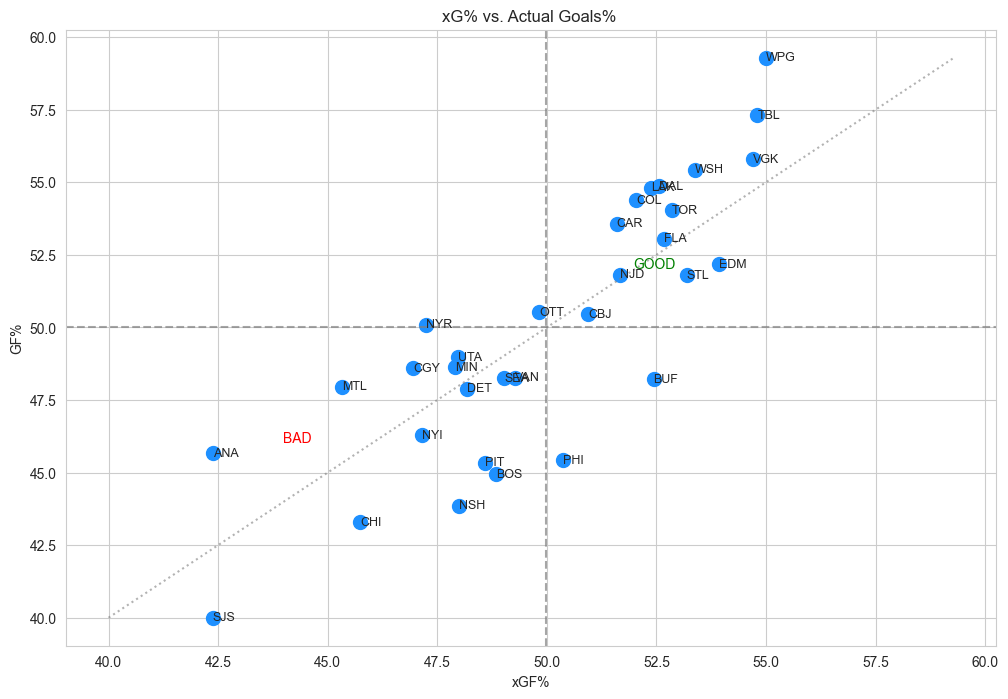

In [133]:
# Graph xG% vs. GF% 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

team_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/season_team_stats.csv')

# 2. Compute League Averages for GF% and xGF%
avg_GF_percent = team_stats['GF%'].mean()
avg_xGF_percent = team_stats['xGF%'].mean()

# 3. Create a Scatter Plot: x-axis = xGF%, y-axis = GF%
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Scatter: each point is a team
plt.scatter(team_stats['xGF%'], team_stats['GF%'], s=100, color='dodgerblue')

# Add vertical and horizontal lines for the league averages
plt.axvline(x=avg_xGF_percent, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=avg_GF_percent, color='gray', linestyle='--', alpha=0.7)

# Label each point with the team abbreviation
for i, row in team_stats.iterrows():
    plt.text(
        row['xGF%'] ,   # small horizontal offset
        row['GF%'], 
        row['Team'],
        fontsize=9,
        ha='left', 
        va='center'
    )

# (y = x):
max_val = max(team_stats['GF%'].max(), team_stats['xGF%'].max())
plt.plot([40, max_val], [40, max_val], color='gray', linestyle=':', alpha=0.6)

# Optionally label quadrants (example):
plt.text(avg_xGF_percent + 2, avg_GF_percent + 2, 'GOOD', fontsize=10, color='green')
plt.text(avg_xGF_percent - 6, avg_GF_percent - 4, 'BAD', fontsize=10, color='red')

plt.xlabel('xGF%')
plt.ylabel('GF%')
plt.title('xG% vs. Actual Goals% ')

# 4. Identify Top 9 / Bottom 9 Teams by dGF% (GF% - xGF%)
df_sorted = team_stats.sort_values('dGF%', ascending=False)
top_9 = df_sorted.head(9)
bottom_9 = df_sorted.tail(9)

print("Top 9 Teams by dGF%:")
print(top_9[['Team', 'GF%', 'xGF%', 'dGF%']])

print("\nBottom 9 Teams by dGF%:")
print(bottom_9[['Team', 'GF%', 'xGF%', 'dGF%']])

# 5. Summaries of League Stats
# Example: total goals, average xGF, average GF, etc.
total_goals_for = team_stats['GF'].sum()
total_xg_for = team_stats['xGF'].sum()
avg_gf_percent = team_stats['GF%'].mean()
avg_xgf_percent = team_stats['xGF%'].mean()

print(f"\nLeague Totals: {len(team_stats)} teams")
print(f"Sum of GF: {total_goals_for}, Sum of xGF: {total_xg_for}")
print(f"Average GF%: {avg_gf_percent:.1f}%, Average xGF%: {avg_xgf_percent:.1f}%")

# 6. Show the Plot
plt.show()


In [134]:
# 4. Identify Top 9 / Bottom 9 Teams by xGF% 
df_sorted = team_stats.sort_values('xGF%', ascending=False)
top_9 = df_sorted.head(9)
bottom_9 = df_sorted.tail(9)

print("Top 9 Teams by xGF%:")
print(top_9[['Team', 'GF%', 'xGF%', 'dGF%']])

print("\nBottom 9 Teams by xGF%:")
print(bottom_9[['Team', 'GF%', 'xGF%', 'dGF%']])

Top 9 Teams by xGF%:
   Team        GF%       xGF%      dGF%
30  WPG  59.290188  54.999486  4.290701
25  TBL  57.309942  54.805847  2.504095
29  VGK  55.800000  54.703105  1.096895
10  EDM  52.173913  53.921799 -1.747886
31  WSH  55.428571  53.371363  2.057209
24  STL  51.807229  53.189769 -1.382540
26  TOR  54.043393  52.848114  1.195278
11  FLA  53.052632  52.679506  0.373126
8   DAL  54.863813  52.558173  2.305641

Bottom 9 Teams by xGF%:
   Team        GF%       xGF%      dGF%
27  UTA  48.983740  47.968401  1.015339
13  MIN  48.625793  47.900873  0.724920
18  NYR  50.097847  47.246199  2.851648
17  NYI  46.280992  47.158685 -0.877693
5   CGY  48.596112  46.954422  1.641691
6   CHI  43.295019  45.739167 -2.444148
14  MTL  47.961165  45.322373  2.638792
23  SJS  40.000000  42.380163 -2.380163
0   ANA  45.661157  42.378153  3.283004


In [135]:
# Calculate team's xGF, xGA per Game 

df_schedule = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/schedule.csv')

# 2. Reshape so each row is (GameID, Team)
df_home = df_schedule[['GameID', 'Team']].rename(columns={'HomeTeam':'Team'})
df_away = df_schedule[['GameID', 'Opponent']].rename(columns={'AwayTeam':'Team'})
df_teams = pd.concat([df_home, df_away], ignore_index=True)

# 3. Count how many times each Team appears => Games Played
df_games_played = df_teams.groupby('Team')['GameID'].nunique().reset_index()
df_games_played.rename(columns={'GameID':'GamesPlayed'}, inplace=True)

# 4. Load your season_team_stats.csv with columns: Team, xGF, xGA, etc.
df_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/season_team_stats.csv')

# 5. Merge in the number of games played
df_stats = pd.merge(df_stats, df_games_played, on='Team', how='left')

# 6. Now compute xGF_per60 and xGA_per60
df_stats['xGF_perGame'] = (df_stats['xGF'] / df_stats['GamesPlayed'])
df_stats['xGA_perGame'] = (df_stats['xGA'] / df_stats['GamesPlayed']) 

# 7. Print and export
print(df_stats[['Team', 'GamesPlayed', 'xGF', 'xGA', 'xGF_perGame', 'xGA_perGame']].head(32))

df_stats.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/season_team_stats_with_rates.csv', index=False)
print("Export complete: season_team_stats_with_rates.csv has been saved.")


   Team  GamesPlayed         xGF         xGA  xGF_perGame  xGA_perGame
0   ANA           82  208.723729  283.802995     2.545411     3.461012
1   BOS           82  222.131066  232.661397     2.708915     2.837334
2   BUF           82  269.157341  244.162611     3.282407     2.977593
3   CAR           83  236.784776  222.191581     2.852829     2.677007
4   CBJ           82  259.544157  249.888288     3.165173     3.047418
5   CGY           82  214.230667  242.021716     2.612569     2.951484
6   CHI           82  222.107589  263.488466     2.708629     3.213274
7   COL           84  245.960491  226.651741     2.928101     2.698235
8   DAL           84  282.979521  255.432504     3.368804     3.040863
9   DET           82  221.565675  238.391404     2.702020     2.907212
10  EDM           83  263.980170  225.580966     3.180484     2.717843
11  FLA           82  237.350138  213.204846     2.894514     2.600059
12  LAK           83  230.530167  209.669279     2.777472     2.526136
13  MI

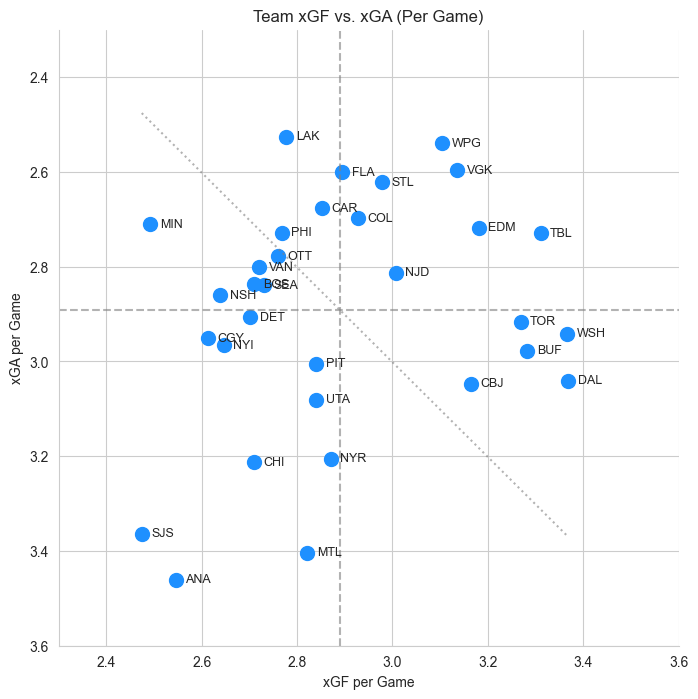

In [137]:
# xGF per Game vs. xGA per game analysis 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Your Updated Season Stats with xGF_perGame and xGA_perGame
df_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/season_team_stats_with_rates.csv')
# Columns expected to include: Team, xGF_perGame, xGA_perGame, GamesPlayed, etc.

# 2. Compute League Averages for xGF_perGame and xGA_perGame
mean_xGF = df_stats['xGF_perGame'].mean()
mean_xGA = df_stats['xGA_perGame'].mean()

# 3. Create the Scatter Plot
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")

# Plot each team as a point
plt.scatter(df_stats['xGF_perGame'], df_stats['xGA_perGame'], s=100, color='dodgerblue')

# Draw vertical/horizontal lines at league averages
plt.axvline(x=mean_xGF, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=mean_xGA, color='gray', linestyle='--', alpha=0.6)

x_vals = np.linspace(df_stats['xGF_perGame'].min(), df_stats['xGF_perGame'].max(), 100)
y_vals = (x_vals - mean_xGF) + mean_xGA
plt.plot(x_vals, y_vals, color='gray', linestyle=':', alpha=0.6)

# Label each point with the team abbreviation
for i, row in df_stats.iterrows():
    plt.text(
        row['xGF_perGame'] + 0.02,  # small horizontal offset
        row['xGA_perGame'],
        row['Team'],
        fontsize=9,
        ha='left',
        va='center'
    )

# 4. Final Touches
plt.xlabel('xGF per Game')
plt.ylabel('xGA per Game')
plt.title("Team xGF vs. xGA (Per Game)")

plt.xlim(2.3, 3.6)
plt.ylim(2.3,3.6)

plt.gca().invert_yaxis() #invery y-axis 
sns.despine()  # remove top/right spines for a cleaner look

plt.show()


In [138]:
# Team's Actual GF, GA 

import pandas as pd
import numpy as np

# 1. Load schedule with columns: GameID, HomeTeam, AwayTeam, ...
df_schedule = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/schedule.csv')

# 2. Reshape so each row is (GameID, Team)
df_home = df_schedule[['GameID', 'Team']].rename(columns={'HomeTeam':'Team'})
df_away = df_schedule[['GameID', 'Opponent']].rename(columns={'AwayTeam':'Team'})
df_teams = pd.concat([df_home, df_away], ignore_index=True)

# 3. Count how many times each Team appears => Games Played
df_games_played = df_teams.groupby('Team')['GameID'].nunique().reset_index()
df_games_played.rename(columns={'GameID':'GamesPlayed'}, inplace=True)

# 4. Load your season_team_stats.csv with columns: Team, xGF, xGA, etc.
df_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/season_team_stats.csv')

# 5. Merge in the number of games played
df_stats = pd.merge(df_stats, df_games_played, on='Team', how='left')

# 6. Now compute xGF_per60 and xGA_per60
df_stats['GF_perGame'] = (df_stats['GF'] / df_stats['GamesPlayed'])
df_stats['GA_perGame'] = (df_stats['GA'] / df_stats['GamesPlayed']) 

# 7. Print and export
print(df_stats[['Team', 'GamesPlayed', 'GF', 'GA', 'GF_perGame', 'GA_perGame']].head())

df_stats.to_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/season_team_gfga.csv', index=False)

  Team  GamesPlayed   GF   GA  GF_perGame  GA_perGame
0  ANA           82  221  263    2.695122    3.207317
1  BOS           82  222  272    2.707317    3.317073
2  BUF           82  269  289    3.280488    3.524390
3  CAR           83  270  234    3.253012    2.819277
4  CBJ           82  273  268    3.329268    3.268293


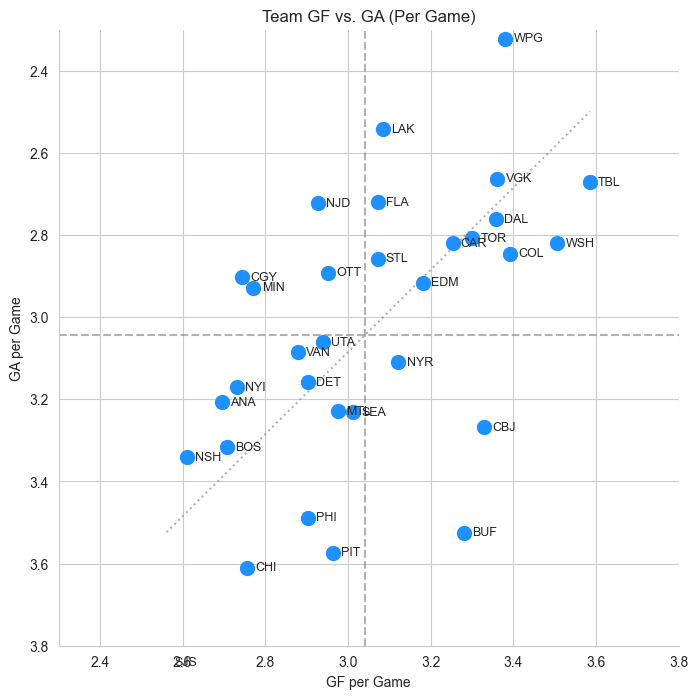

In [139]:
# GF VS. GA Graph 

df_stats = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/season_team_gfga.csv')

# 2. Compute League Averages for xGF_perGame and xGA_perGame
mean_xGF = df_stats['GF_perGame'].mean()
mean_xGA = df_stats['GA_perGame'].mean()

# 3. Create the Scatter Plot
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")

# Plot each team as a point
plt.scatter(df_stats['GF_perGame'], df_stats['GA_perGame'], s=100, color='dodgerblue')

# Draw vertical/horizontal lines at league averages
plt.axvline(x=mean_xGF, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=mean_xGA, color='gray', linestyle='--', alpha=0.6)

x_vals = np.linspace(df_stats['GF_perGame'].min(), df_stats['GF_perGame'].max(), 100)
y_vals = -(x_vals - mean_xGF) + mean_xGA
plt.plot(x_vals, y_vals, color='gray', linestyle=':', alpha=0.6)

# Label each point with the team abbreviation
for i, row in df_stats.iterrows():
    plt.text(
        row['GF_perGame'] + 0.02,  # small horizontal offset
        row['GA_perGame'],
        row['Team'],
        fontsize=9,
        ha='left',
        va='center'
    )

# 4. Final Touches
plt.xlabel('GF per Game')
plt.ylabel('GA per Game')
plt.title("Team GF vs. GA (Per Game)")

plt.xlim(2.3, 3.8)
plt.ylim(2.3,3.8) 

plt.gca().invert_yaxis() #invery y-axis 
sns.despine()  # remove top/right spines for a cleaner look

plt.show() 

In [140]:
# Top 10 Players xG 

# 1. Read the xG results
df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xg_results.csv')   

# 2. Compute total xG per player (Player1)
df_player_xg = (
    df_xg.groupby('Player1', as_index=False)
         .agg({'xG': 'sum', 'Goal': 'sum'})
         .rename(columns={'xG': 'Total_xG', 'Goal': 'Total_Goals'})
)

# 3. Read the player CSV
df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')  

# 4. Merge the total xG with the player info
df_merged = pd.merge(
    df_player_xg, 
    df_players[['playerId','Player']],  # or more columns if needed
    left_on='Player1',
    right_on='playerId',
    how='left'
)

# 5. Sort descending by xG and select top 20
df_top20 = df_merged.sort_values("Total_xG", ascending=False).head(20)

# 6. Print the results
print("Top 20 players by total xG:")

print(df_top20[['Player1', 'Player', 'Total_xG', 'Total_Goals']])

Top 20 players by total xG:
     Player1            Player   Total_xG  Total_Goals
276  8477934    Leon Draisaitl  60.895255           51
447  8479420     Tage Thompson  48.223098           42
279  8477939  William Nylander  46.322492           43
3    8471214     Alex Ovechkin  43.480645           38
330  8478398       Kyle Connor  42.730111           42
149  8476460    Mark Scheifele  40.755192           39
286  8477949         Alex Tuch  40.599371           38
292  8477956    David Pastrnak  40.447986           40
303  8478010     Brayden Point  39.584897           41
628  8481540     Cole Caufield  39.123858           40
226  8477404     Jake Guentzel  38.524752           39
500  8480027   Jason Robertson  37.214326           36
275  8477933      Sam Reinhart  37.168879           39
434  8479385      Jordan Kyrou  36.570434           36
143  8476453   Nikita Kucherov  36.216944           36
415  8479337    Alex DeBrincat  36.006420           37
56   8475166      John Tavares  35.94

In [141]:
df_topg20 = df_merged.sort_values("Total_Goals", ascending=False).head(20)

# 6. Print the results
print("Top 20 players by total Goals:")

print(df_topg20[['Player1', 'Player', 'Total_xG', 'Total_Goals']])

Top 20 players by total Goals:
     Player1            Player   Total_xG  Total_Goals
276  8477934    Leon Draisaitl  60.895255           51
279  8477939  William Nylander  46.322492           43
330  8478398       Kyle Connor  42.730111           42
447  8479420     Tage Thompson  48.223098           42
303  8478010     Brayden Point  39.584897           41
292  8477956    David Pastrnak  40.447986           40
628  8481540     Cole Caufield  39.123858           40
226  8477404     Jake Guentzel  38.524752           39
149  8476460    Mark Scheifele  40.755192           39
275  8477933      Sam Reinhart  37.168879           39
3    8471214     Alex Ovechkin  43.480645           38
286  8477949         Alex Tuch  40.599371           38
56   8475166      John Tavares  35.946970           37
415  8479337    Alex DeBrincat  36.006420           37
281  8477942       Kevin Fiala  35.646293           36
434  8479385      Jordan Kyrou  36.570434           36
657  8481604   Pavel Dorofeyev  35

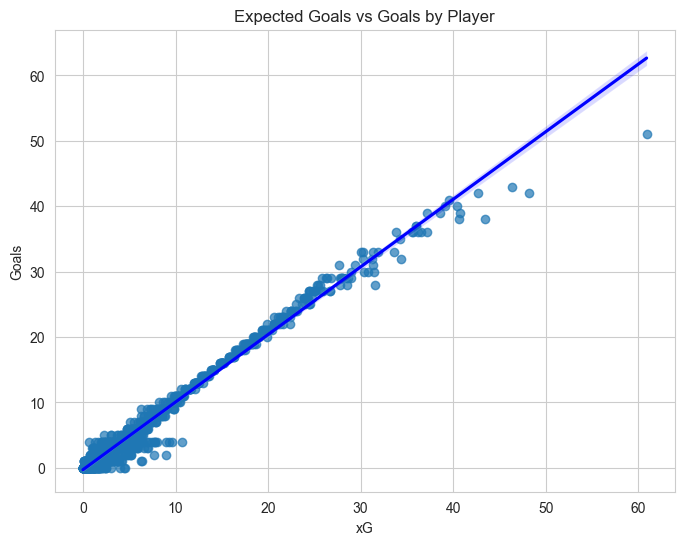

Model Evaluation Metrics:
  Pearson Correlation (Goals vs xG): 0.990
  R^2: 0.979
  RMSE: 1.405


In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

df_xg = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xg_results.csv')

# 2. Compute total xG and total goals per player
df_player_xg = (
    df_xg.groupby('Player1', as_index=False)
         .agg({'xG': 'sum', 'Goal': 'sum'})
         .rename(columns={'xG': 'Total_xG', 'Goal': 'Total_Goals'})
)

df_players = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')

# 4. Merge xG/goals with player info
#    (Match Player1 with playerId)
df_merged = pd.merge(
    df_player_xg,
    df_players[['playerId', 'Player']],  # pick any extra columns if needed
    left_on='Player1',
    right_on='playerId',
    how='left'
)

# 5. Create a scatter plot with regression line
#    using seaborn's regplot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

sns.regplot(
    data=df_merged,
    x='Total_xG',
    y='Total_Goals',
    scatter_kws={'alpha': 0.7},  # transparency of the dots
    line_kws={'color': 'blue'}
)

plt.title("Expected Goals vs Goals by Player")
plt.xlabel("xG")
plt.ylabel("Goals")

plt.show()


# Model Evaluation based on Players' Goal vs. xG 

# Pearson correlation
pearson_corr = df_merged[['Total_xG','Total_Goals']].corr(method='pearson').iloc[0,1]

# R^2 (coefficient of determination)
r2 = r2_score(df_merged['Total_Goals'], df_merged['Total_xG'])

# RMSE (root mean squared error)
rmse = np.sqrt(mean_squared_error(df_merged['Total_Goals'], df_merged['Total_xG']))

print("Model Evaluation Metrics:")
print(f"  Pearson Correlation (Goals vs xG): {pearson_corr:.3f}")
print(f"  R^2: {r2:.3f}")
print(f"  RMSE: {rmse:.3f}")


In [182]:
# Goalie Analysis 

import pandas as pd

# 1. Load your data
df_xg_filtered = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xg_results.csv')

# 3. Compute total xG and goals per goalie, then rename Goalie→playerId
df_goalie_xg = (
    df_xg_filtered
      .groupby('Goalie', as_index=False)
      .agg(Total_xG=('xG', 'sum'),
           Total_Goals=('Goal', 'sum'))
      .rename(columns={'Goalie': 'playerId'})
)

# 4. Read the player CSV
df_goalies = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')

# 5. Merge on playerId
df_merged1 = pd.merge(
    df_goalie_xg,
    df_goalies[['playerId', 'Player']],      
    on='playerId',
    how='left'
)

df_merged1['GSAx'] = df_merged1['Total_xG'] - df_merged1['Total_Goals']

avg_gsax = df_merged1['GSAx'].mean()
num_goalies = df_merged1.shape[0]

# Show your Top-10 and the new summary stats
df_top20 = df_merged1.sort_values('GSAx', ascending=True).head(10)

print("Top 10 goalies by GSAx (Total_xG - Total_Goals):")
print(df_top20[['playerId', 'Player', 'Total_xG', 'Total_Goals', 'GSAx']])
print()  # blank line for readability
print(f"Across all {num_goalies} goalies, average GSAx = {avg_gsax:.4f}")

Top 10 goalies by GSAx (Total_xG - Total_Goals):
     playerId                Player    Total_xG  Total_Goals       GSAx
73  8481035.0         Samuel Ersson  117.359448          140 -22.640552
65  8480382.0    Alexandar Georgiev  147.829771          168 -20.170229
59  8480045.0  Ukko-Pekka Luukkonen  153.607763          172 -18.392237
12  8475831.0      Philipp Grubauer   69.999368           88 -18.000632
32  8477968.0      Alex Nedeljkovic  105.079596          121 -15.920404
56  8479496.0         David Rittich   74.367141           90 -15.632859
48  8478905.0          Ivan Fedotov   63.489345           78 -14.510655
63  8480280.0        Jeremy Swayman  162.551641          177 -14.448359
14  8475852.0           Petr Mrazek  104.199431          118 -13.800569
36  8478007.0      Elvis Merzlikins  156.810443          169 -12.189557

Across all 103 goalies, average GSAx = -0.0046


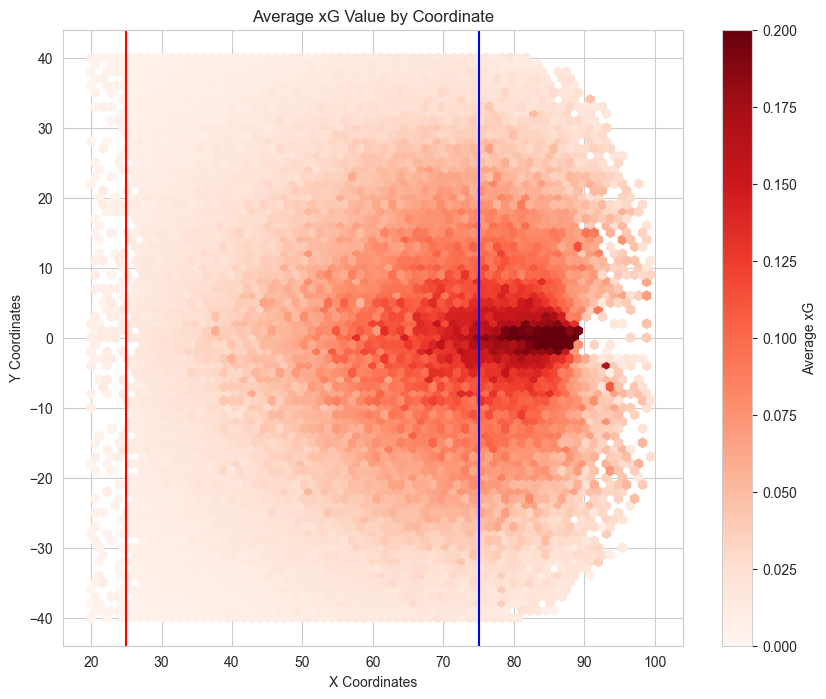

In [110]:
# xG by on ice position graph 

df = pd.read_csv('/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xg_results.csv')

# 2. Filter to only include data where X >= 0
df = df[(df["X"] >= 0) & (df["Y"].abs() <= 40)]

# 3. Create the figure
plt.figure(figsize=(10, 8))

# 4. Plot a 2D hexbin, coloring by average xG in each bin
#    - reduce_C_function=np.mean calculates the mean xG per hex cell
#    - gridsize adjusts the resolution (try different values)
#    - extent sets the x/y axis boundaries
hb = plt.hexbin(
    df["X"], df["Y"], C=df["xG"],
    gridsize=70,
    reduce_C_function=np.mean,
    cmap="Reds",
    extent=(20, 100, -40, 40),  # X from 0 to 100, Y from -50 to 50
    vmin=0, vmax=0.2
)

# 5. Add colorbar
cb = plt.colorbar(hb, label="Average xG")

# 6. add vertical lines at x=25 or x=75 
plt.axvline(x=25, color="red", linewidth=1.5)
plt.axvline(x=75, color="blue", linewidth=1.5)

# 7. Label and title
plt.title("Average xG Value by Coordinate")
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")

plt.show()


Enter a playerId:  8474189


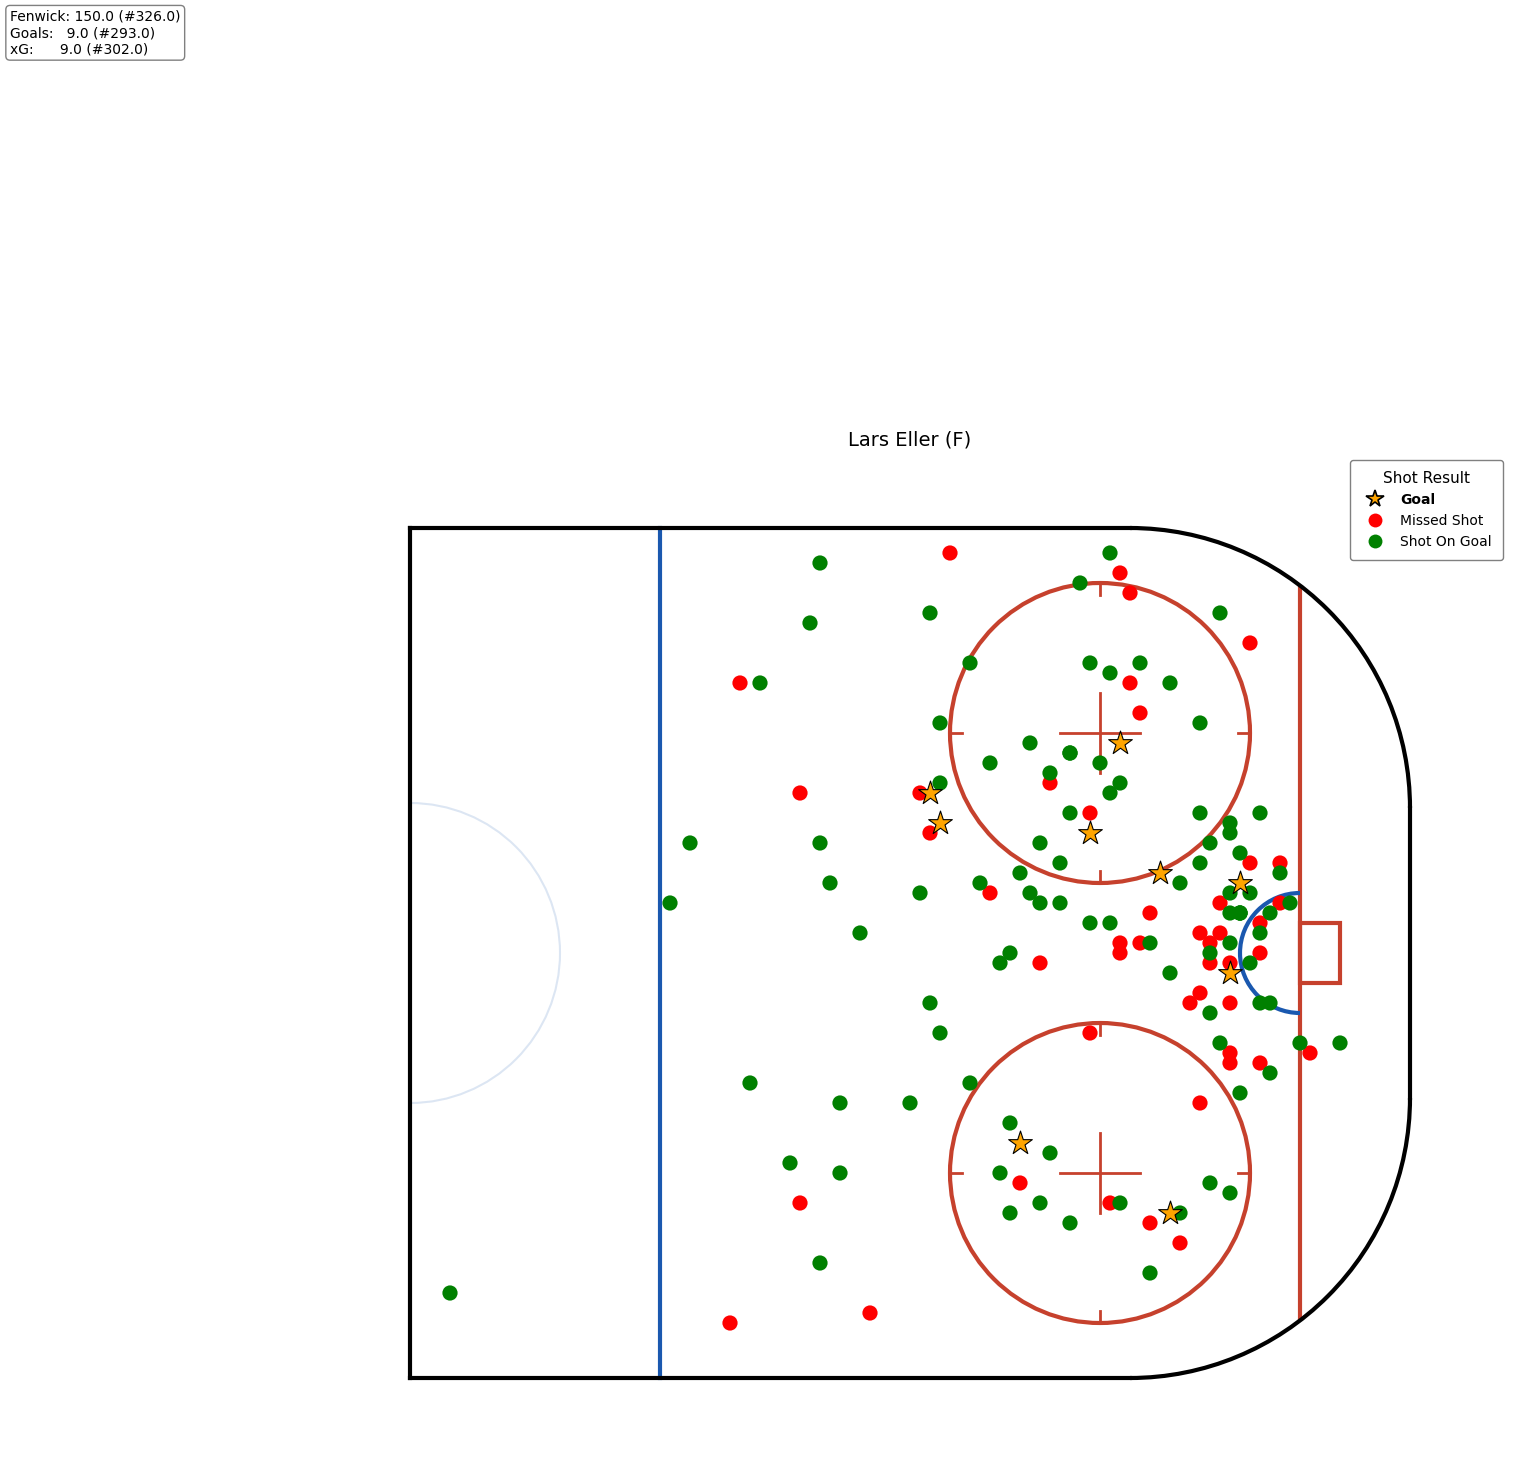

In [2]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, Circle, Arc
from matplotlib.lines import Line2D

# ─────────────────── RINK ────────────────────────────────────────────
def draw_half_nhl_rink(ax=None):
    ICE, BOARDS, RED, BLUE = "white", "black", "#c6412d", "#1a58af"
    LW_BOARDS, LW_LINES = 3, 3

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    ax.set_facecolor(ICE)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_xlim(-10, 110)
    ax.set_ylim(-50, 50)

    # ice fill
    ax.add_patch(Rectangle((0, -42.5), 72, 85,
                           facecolor=ICE, edgecolor='none'))

    # goal line
    ax.plot([89, 89], [-36.5, 36.5], color=RED, lw=LW_LINES, zorder=1)

    # boards
    ax.plot([0, 0],   [-42.5, 42.5], color=BOARDS, lw=LW_BOARDS, zorder=3)
    ax.plot([0, 72],  [42.5, 42.5],  color=BOARDS, lw=LW_BOARDS, zorder=3)
    ax.plot([0, 72],  [-42.5, -42.5], color=BOARDS, lw=LW_BOARDS, zorder=3)

    # rounded corners
    for y0, t1, t2 in [(14.5, 0, 90), (-14.5, -90, 0)]:
        ax.add_patch(Arc((72, y0), 56, 56, theta1=t1, theta2=t2,
                         edgecolor=BOARDS, lw=LW_BOARDS, zorder=3))

    # end boards
    ax.plot([100, 100], [-14.5, 14.5], color=BOARDS,
            lw=LW_BOARDS, zorder=3)

    # blue line
    ax.plot([25, 25], [-42.5, 42.5], color=BLUE,
            lw=LW_LINES, zorder=2)

    # goal crease & net
    ax.add_patch(Arc((89, 0), 12, 12, theta1=90, theta2=270,
                     edgecolor=BLUE, lw=LW_LINES, zorder=4))
    ax.add_patch(Rectangle((89, -3), 4, 6, fill=False,
                           edgecolor=RED, lw=LW_LINES, zorder=4))

    # face-off circles
    for y in (22, -22):
        ax.add_patch(Circle((69, y), 15, fill=False,
                            edgecolor=RED, lw=LW_LINES, zorder=2))
        ax.plot([69-4, 69+4], [y, y], color=RED, lw=LW_LINES-1, zorder=2)
        ax.plot([69, 69], [y-4, y+4], color=RED, lw=LW_LINES-1, zorder=2)
        for ang in (0, 90, 180, 270):
            x_off = 15 * np.cos(np.deg2rad(ang))
            y_off = 15 * np.sin(np.deg2rad(ang))
            tick = 1.2
            ax.plot([69+x_off*0.92, 69+x_off*(0.92+tick/15)],
                    [y+y_off*0.92,  y+y_off*(0.92+tick/15)],
                    color=RED, lw=LW_LINES-1, zorder=2)

    # faint centre guides
    ax.plot([0, 0], [-42.5, 42.5], color=BLUE, lw=1, alpha=.15, zorder=1)
    ax.add_patch(Arc((0, 0), 30, 30, theta1=270, theta2=90,
                     edgecolor=BLUE, lw=1.5, alpha=.15, zorder=1))

    return fig, ax

# ───────────────── PLAYER SHOT MAP ───────────────────────────────────
def plot_player_shots(df_events, df_players, player_id):
    # merge player meta
    cols = ['playerId'] + [c for c in ['Player']
                           if c in df_players.columns]
    df = df_events.merge(df_players[cols],
                         left_on='Player1', right_on='playerId', how='left')

    # per-player aggregates
    summary = (df.groupby('Player1')
                 .agg(fenwick=('Event', lambda s: s.isin(
                       ['goal', 'shot-on-goal', 'missed-shot']).sum()),
                      goals=('Event', lambda s: (s == 'goal').sum()),
                      xG=('xG', 'sum'))
                 .assign(goals_rank   =lambda d: d['goals']
                                          .rank(ascending=False,
                                                method='min').astype(int),
                         fenwick_rank =lambda d: d['fenwick']
                                          .rank(ascending=False,
                                                method='min').astype(int),
                         xg_rank      =lambda d: d['xG']
                                          .rank(ascending=False,
                                                method='min').astype(int))
               )

    shots = df.query('Player1 == @player_id').copy()
    if shots.empty:
        print(f"No shots for playerId {player_id}")
        return

    meta  = shots.iloc[0]
    stats = summary.loc[player_id]

    # rink
    fig, ax = plt.subplots(figsize=(12, 10))
    draw_half_nhl_rink(ax)

    # colours
    colour_map = {'goal': 'orange', 'shot-on-goal': 'green',
                  'missed-shot': 'red'}

    # plot each event type – ★ for goals
    # base sizes multiplied by 1.5
    BASE_CIRCLE = 60 * 2   # 90
    BASE_STAR   = 80 * 4   # 120
    for evt, grp in shots.groupby('Event'):
        ax.scatter(
            grp['X'], grp['Y'],
            s=BASE_STAR if evt == 'goal' else BASE_CIRCLE,
            c=colour_map[evt],
            alpha=1,
            marker='*' if evt == 'goal' else 'o',
            edgecolor='black' if evt == 'goal' else 'none',
            linewidths=.8 if evt == 'goal' else 0,
            zorder=5 if evt == 'goal' else 4,
            label=evt.replace('-', ' ').title()
        )

    # title
    team_str = f" – {meta.Team}" if 'Team' in meta and pd.notna(meta.Team) else ""
    ax.set_title(f"{meta.Player} ({meta.Position}){team_str}", fontsize=14)

    # summary box
    ax.text(-40, 90,
            (f"Fenwick: {stats.fenwick} (#{stats.fenwick_rank})\n"
             f"Goals:   {stats.goals} (#{stats.goals_rank})\n"
             f"xG:      {stats.xG:.1f} (#{stats.xg_rank})"),
            fontsize=10,
            bbox=dict(boxstyle="round", fc="white", ec="gray"))

    # ── enhanced legend ───────────────────────────────────────────────
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    handles = [
        Line2D([], [], marker='*', markersize=13, markeredgewidth=1.2,
               markeredgecolor='black', markerfacecolor='orange',
               linestyle='None', label='Goal'),
        Line2D([], [], marker='o', markersize=10,
               markerfacecolor='red', markeredgecolor='none',
               linestyle='None', label='Missed Shot'),
        Line2D([], [], marker='o', markersize=10,
               markerfacecolor='green', markeredgecolor='none',
               linestyle='None', label='Shot On Goal'),
    ]

    legend = ax.legend(handles=handles, loc='upper right',
                       title='Shot Result', title_fontsize=11,
                       frameon=True, framealpha=1, fancybox=True,
                       borderpad=0.8, edgecolor='grey')

    for txt in legend.get_texts():
        if txt.get_text() == 'Goal':
            txt.set_fontweight('bold')

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

# ───────────────── ENTRY ─────────────────────────────────────────────
if __name__ == "__main__":
    df_events = pd.read_csv(
        '/Users/meiza/Desktop/NHL Modeling/xG Model Shootertalent/xg_results.csv')
    df_players = pd.read_csv(
        '/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv')

    try:
        pid = int(input("Enter a playerId: ").strip())
    except ValueError:
        print("Invalid input – please enter an integer ID.")
        exit(1)

    plot_player_shots(df_events, df_players, pid)


Enter a playerId:  8474189


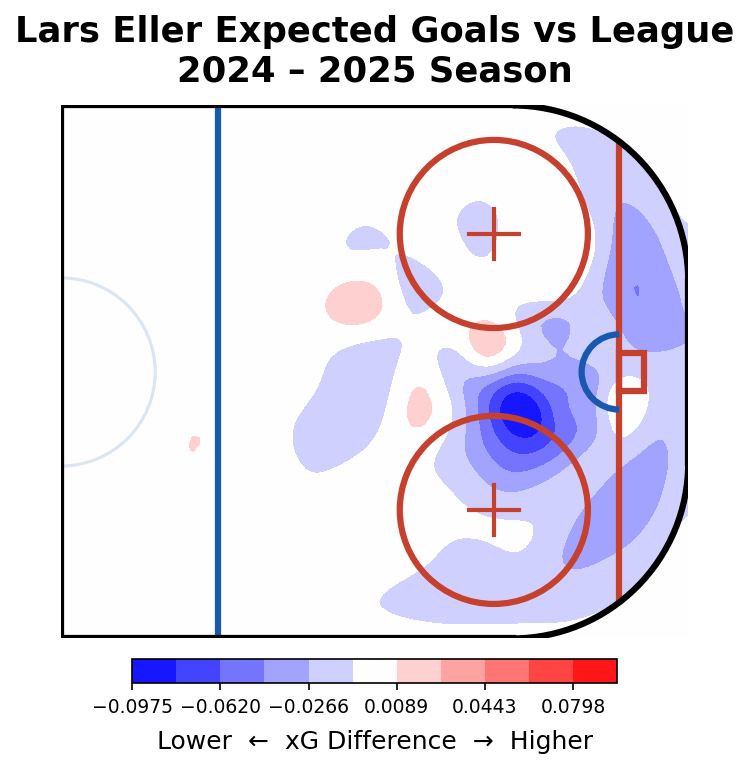

In [68]:
#!/usr/bin/env python3
# Player-vs-League xG contour – covers full half-rink

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# ───────── rink-drawing (unchanged) ─────────
def draw_half_nhl_rink(ax=None):
    ICE, BOARDS, RED, BLUE = "white", "black", "#c6412d", "#1a58af"
    LW_BOARDS, LW_LINES = 3, 3

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    ax.set_facecolor(ICE)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_xlim(-10, 110)
    ax.set_ylim(-50, 50)

    # ice fill  (zorder 1)
    ax.add_patch(Rectangle((0, -42.5), 72, 85,
                           facecolor=ICE, edgecolor='none', zorder=1))

    # goal line
    ax.plot([89, 89], [-36.5, 36.5], color=RED, lw=LW_LINES, zorder=4)

    # boards
    ax.plot([0, 0],   [-42.5, 42.5], color=BOARDS, lw=LW_BOARDS, zorder=6)
    ax.plot([0, 72],  [42.5, 42.5],  color=BOARDS, lw=LW_BOARDS, zorder=6)
    ax.plot([0, 72],  [-42.5, -42.5], color=BOARDS, lw=LW_BOARDS, zorder=6)

    # rounded corners
    for y0, t1, t2 in [(14.5, 0, 90), (-14.5, -90, 0)]:
        ax.add_patch(Arc((72, y0), 56, 56, theta1=t1, theta2=t2,
                         edgecolor=BOARDS, lw=LW_BOARDS, zorder=6))

    # end boards
    ax.plot([100, 100], [-14.5, 14.5], color=BOARDS, lw=LW_BOARDS, zorder=6)

    # blue line
    ax.plot([25, 25], [-42.5, 42.5], color=BLUE, lw=LW_LINES, zorder=4)

    # goal crease & net
    ax.add_patch(Arc((89, 0), 12, 12, theta1=90, theta2=270,
                     edgecolor=BLUE, lw=LW_LINES, zorder=5))
    ax.add_patch(Rectangle((89, -3), 4, 6, fill=False,
                           edgecolor=RED, lw=LW_LINES, zorder=5))

    # face-off circles
    for y in (22, -22):
        ax.add_patch(Circle((69, y), 15, fill=False,
                            edgecolor=RED, lw=LW_LINES, zorder=4))
        ax.plot([69-4, 69+4], [y, y], color=RED, lw=LW_LINES-1, zorder=4)
        ax.plot([69, 69], [y-4, y+4], color=RED, lw=LW_LINES-1, zorder=4)

    # faint centre guides
    ax.plot([0, 0], [-42.5, 42.5], color=BLUE, lw=1, alpha=.15, zorder=3)
    ax.add_patch(Arc((0, 0), 30, 30, theta1=270, theta2=90,
                     edgecolor=BLUE, lw=1.5, alpha=.15, zorder=3))

    return fig, ax

# ───────── parameters ─────────
EVENTS_CSV  = "/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv"
PLAYERS_CSV = "/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv" 

SIGMA  = 3
LEVELS = 12
X_GRID = np.linspace(0, 100, 101)
Y_GRID = np.linspace(-42.5, 42.5, 86)
XG, YG = np.meshgrid(X_GRID, Y_GRID)

# ───────── main ─────────
def main():
    events  = pd.read_csv(EVENTS_CSV)
    players = pd.read_csv(PLAYERS_CSV)

    try:
        pid = int(input("Enter a playerId: ").strip())
    except ValueError:
        print("Invalid ID"); return

    pname = players.loc[players['playerId'] == pid, 'Player'].iloc[0] \
            if 'playerId' in players.columns else f"Player {pid}"

    oz = events[(events.X >= 0) & (events.Y.abs() <= 40)]

    league_grid   = griddata((oz.X, oz.Y), oz.xG, (XG, YG),
                             method='cubic', fill_value=0)
    league_smooth = gaussian_filter(np.maximum(league_grid, 0), sigma=SIGMA)

    pf = oz[oz.Player1 == pid]
    if pf.empty:
        print("No shots for that player."); return
    player_grid   = griddata((pf.X, pf.Y), pf.xG, (XG, YG),
                             method='cubic', fill_value=0)
    player_smooth = gaussian_filter(np.maximum(player_grid, 0), sigma=SIGMA)

    diff = player_smooth - league_smooth
    dmin, dmax = diff.min(), diff.max()
    if abs(dmin) > dmax:
        dmax = -dmin
    else:
        dmin = -dmax

    # ─── plot ───
    fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
    draw_half_nhl_rink(ax)
    cf = ax.contourf(
        X_GRID, Y_GRID, diff,
        levels=np.linspace(dmin, dmax, LEVELS),
        cmap='bwr',
        vmin=dmin, vmax=dmax,
        alpha=1.0,
        zorder=2          # ← below all rink markings, above ice
    )

    ax.set_xlim(0, 100); ax.set_ylim(-42.5, 42.5)
    ax.axis('off')
    ax.set_title(
        f"{pname} Expected Goals vs League\n"
        "2024 – 2025 Season",
        fontweight='bold', fontsize=17, pad=12
    )

    cbar = fig.colorbar(cf, orientation='horizontal',
                        pad=0.035, fraction=0.042)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Lower  ←  xG Difference  →  Higher",
                   fontsize=12, labelpad=6)

    plt.show()

if __name__ == "__main__":
    main()



GOALIE WEAKNESS ANALYZER

Available columns in events data:
['Player1', 'Goalie', 'playerId']



Enter a goalie ID (from players.csv playerId column):  8478007



Analyzing: Elvis Merzlikins (ID: 8478007)
Using column 'Goalie' for goalie identification
Found 2310 shots faced by Elvis Merzlikins
Calculating league average...
Calculating goalie-specific performance...
Generating visualization...


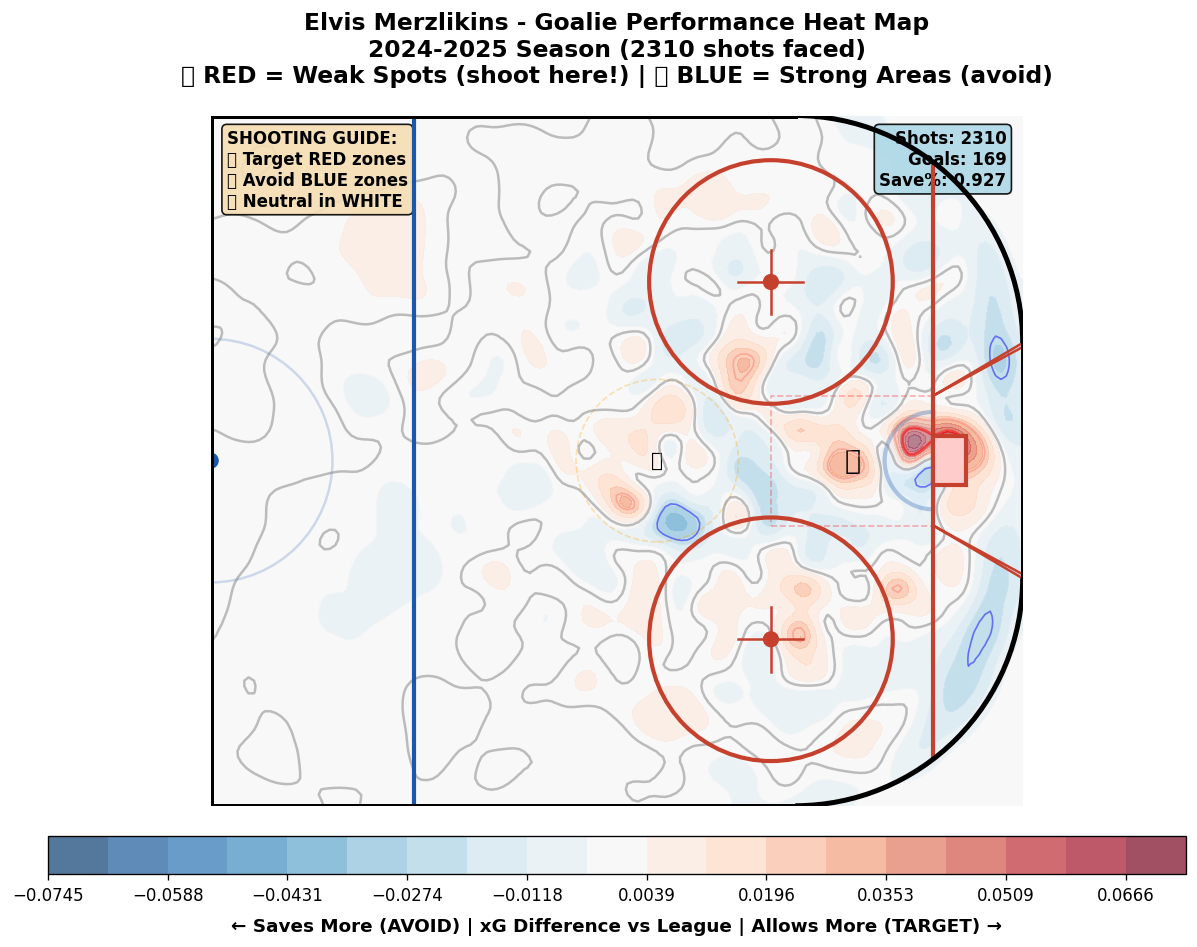


ANALYSIS COMPLETE

🎯 BIGGEST WEAKNESS DETECTED:
   Location: X=86.7, Y=2.3
   xG Differential: +0.074 (allows more goals)
   → RECOMMENDATION: Primary shooting target!

──────────────────────────────────────────────────────────────────────
DETAILED SHOT ANALYSIS FOR WEAKNESS AREA
──────────────────────────────────────────────────────────────────────

Shots in weakness zone (within 10ft radius): 374

📊 SHOT TYPE BREAKDOWN:

   BACKHAND:
      Shots: 60 | Goals: 8 | Conversion: 13.3%
      Avg xG: 0.127

   BAT:
      Shots: 7 | Goals: 1 | Conversion: 14.3%
      Avg xG: 0.178

   BETWEEN-LEGS:
      Shots: 1 | Goals: 0 | Conversion: 0.0%
      Avg xG: 0.056

   CRADLE:
      Shots: 1 | Goals: 0 | Conversion: 0.0%
      Avg xG: 0.083

   DEFLECTED:
      Shots: 20 | Goals: 2 | Conversion: 10.0%
      Avg xG: 0.126

   POKE:
      Shots: 3 | Goals: 0 | Conversion: 0.0%
      Avg xG: 0.194

   SLAP:
      Shots: 2 | Goals: 0 | Conversion: 0.0%
      Avg xG: 0.340

   SNAP:
      Shots: 51

<Figure size 640x480 with 0 Axes>

In [15]:
#!/usr/bin/env python3
"""
Goalie Performance Heatmap  
Shows where goalies tend to perform better or worse than league average
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc, Wedge
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

# ───────── Simplified Rink Drawing (without fill issues) ─────────
def draw_half_nhl_rink(ax=None):
    """Draw a detailed half NHL rink"""
    ICE, BOARDS, RED, BLUE = "white", "black", "#c6412d", "#1a58af"
    LW_BOARDS, LW_LINES = 3, 2.5
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))
    else:
        fig = ax.figure
    
    ax.set_facecolor(ICE)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_xlim(-10, 110)
    ax.set_ylim(-50, 50)
    
    # Ice surface
    ax.add_patch(Rectangle((0, -42.5), 100, 85,
                           facecolor=ICE, edgecolor='none', zorder=1))
    
    # Goal line
    ax.plot([89, 89], [-36.5, 36.5], color=RED, lw=LW_LINES, zorder=4)
    
    # Boards
    ax.plot([0, 0], [-42.5, 42.5], color=BOARDS, lw=LW_BOARDS, zorder=6)
    ax.plot([0, 72], [42.5, 42.5], color=BOARDS, lw=LW_BOARDS, zorder=6)
    ax.plot([0, 72], [-42.5, -42.5], color=BOARDS, lw=LW_BOARDS, zorder=6)
    
    # Rounded corners
    for y0, t1, t2 in [(14.5, 0, 90), (-14.5, -90, 0)]:
        ax.add_patch(Arc((72, y0), 56, 56, theta1=t1, theta2=t2,
                        edgecolor=BOARDS, lw=LW_BOARDS, zorder=6))
    
    # End boards
    ax.plot([100, 100], [-14.5, 14.5], color=BOARDS, lw=LW_BOARDS, zorder=6)
    
    # Blue line
    ax.plot([25, 25], [-42.5, 42.5], color=BLUE, lw=LW_LINES, zorder=4)
    
    # Goal crease (using Wedge instead of Arc for fill capability)
    # Draw crease as a filled semi-circle
    crease = Wedge((89, 0), 6, 90, 270, facecolor='#e6f3ff', 
                   edgecolor=BLUE, lw=LW_LINES, alpha=0.3, zorder=3)
    ax.add_patch(crease)
    
    # Goal net
    ax.add_patch(Rectangle((89, -3), 4, 6, fill=True,
                           facecolor='#ffcccc', edgecolor=RED, 
                           lw=LW_LINES, zorder=5))
    
    # Face-off circles
    for y in (22, -22):
        # Main circle
        ax.add_patch(Circle((69, y), 15, fill=False,
                           edgecolor=RED, lw=LW_LINES, zorder=4))
        # Face-off dot
        ax.add_patch(Circle((69, y), 1, fill=True,
                           facecolor=RED, zorder=5))
        # Hash marks
        ax.plot([69-4, 69+4], [y, y], color=RED, lw=LW_LINES-1, zorder=4)
        ax.plot([69, 69], [y-4, y+4], color=RED, lw=LW_LINES-1, zorder=4)
    
    # Neutral zone face-off dot
    ax.add_patch(Circle((0, 0), 1, fill=True, facecolor=BLUE, zorder=5))
    
    # Center ice circle (faint)
    ax.add_patch(Circle((0, 0), 15, fill=False,
                       edgecolor=BLUE, lw=1.5, alpha=0.2, zorder=3))
    
    # Trapezoid behind goal
    trap_x = [89, 100, 100, 89]
    trap_y1 = [-8, -14, -14.5, -8]
    trap_y2 = [8, 14, 14.5, 8]
    ax.plot(trap_x + [89], trap_y1 + [-8], color=RED, lw=1.5, zorder=4)
    ax.plot(trap_x + [89], trap_y2 + [8], color=RED, lw=1.5, zorder=4)
    
    return fig, ax

# ───────── Add Shooting Zones ─────────
def add_shooting_zones(ax):
    """Add visual indicators for key shooting areas"""
    # Slot area (high-danger zone)
    slot_x = [69, 89, 89, 69, 69]
    slot_y = [-8, -8, 8, 8, -8]
    ax.plot(slot_x, slot_y, 'r-', alpha=0.3, lw=1, linestyle='--', zorder=3)
    
    # High slot
    high_slot = Circle((55, 0), 10, fill=False, edgecolor='orange',
                      alpha=0.3, lw=1, linestyle='--', zorder=3)
    ax.add_patch(high_slot)
    
    # Add target markers
    ax.text(79, 0, '🎯', fontsize=16, ha='center', va='center', zorder=3)
    ax.text(55, 0, '🎯', fontsize=12, ha='center', va='center', zorder=3)

# ───────── Parameters ─────────
EVENTS_CSV = "/Users/meiza/Desktop/NHL Modeling/xG Model/xg_results.csv"
PLAYERS_CSV = "/Users/meiza/Desktop/NHL Modeling/xG Model/players.csv"

SIGMA = 2.5
LEVELS = 20
X_GRID = np.linspace(0, 100, 151)
Y_GRID = np.linspace(-42.5, 42.5, 128)
XG, YG = np.meshgrid(X_GRID, Y_GRID)

# ───────── Main Function ─────────
def main():
    """Main function to generate goalie performance heatmap"""
    
    # Load data
    try:
        events = pd.read_csv(EVENTS_CSV)
        players = pd.read_csv(PLAYERS_CSV)
        print("\n" + "="*70)
        print("GOALIE WEAKNESS ANALYZER")
        print("="*70)
    except FileNotFoundError as e:
        print(f"Error loading files: {e}")
        return
    
    # Show available columns for debugging
    print("\nAvailable columns in events data:")
    print([col for col in events.columns if 'oalie' in col.lower() or 'layer' in col])
    
    # Get goalie ID from user
    try:
        goalie_id = int(input("\nEnter a goalie ID (from players.csv playerId column): ").strip())
    except ValueError:
        print("Invalid ID. Please enter a numeric goalie ID.")
        return
    
    # Get goalie name from players.csv
    goalie_info = players[players['playerId'] == goalie_id]
    if not goalie_info.empty:
        goalie_name = goalie_info['Player'].iloc[0]
        print(f"\nAnalyzing: {goalie_name} (ID: {goalie_id})")
    else:
        print(f"\nWarning: Goalie ID {goalie_id} not found in players.csv")
        goalie_name = f"Goalie {goalie_id}"
    
    # Filter for offensive zone shots
    oz_shots = events[(events['X'] >= 0) & (events['Y'].abs() <= 42.5)]
    
    # Try to identify the goalie column
    # Common column names for goalies in hockey data
    potential_goalie_cols = ['GoalieId', 'goalieIdForShot', 'goalieId', 'Goalie', 
                             'Player2', 'player2Id', 'defendingPlayerId']
    
    goalie_col = None
    for col in potential_goalie_cols:
        if col in oz_shots.columns:
            goalie_col = col
            print(f"Using column '{col}' for goalie identification")
            break
    
    if goalie_col is None:
        print("\nError: Could not identify goalie column in the data.")
        print("Available columns in your data:")
        print(list(oz_shots.columns))
        print("\nPlease check your data structure and ensure there's a column identifying the goalie.")
        return
    
    # Filter shots faced by this goalie
    goalie_shots = oz_shots[oz_shots[goalie_col] == goalie_id]
    
    if goalie_shots.empty:
        print(f"\nNo shots faced data found for goalie ID {goalie_id}")
        print(f"Unique goalie IDs in the data (first 10): {oz_shots[goalie_col].unique()[:10]}")
        return
    
    print(f"Found {len(goalie_shots)} shots faced by {goalie_name}")
    
    # Calculate league average xG surface
    print("Calculating league average...")
    league_grid = griddata(
        (oz_shots['X'].values, oz_shots['Y'].values),
        oz_shots['xG'].values,
        (XG, YG),
        method='cubic',
        fill_value=0
    )
    league_smooth = gaussian_filter(np.maximum(league_grid, 0), sigma=SIGMA)
    
    # Calculate goalie-specific xG surface
    print("Calculating goalie-specific performance...")
    goalie_grid = griddata(
        (goalie_shots['X'].values, goalie_shots['Y'].values),
        goalie_shots['xG'].values,
        (XG, YG),
        method='cubic',
        fill_value=0
    )
    goalie_smooth = gaussian_filter(np.maximum(goalie_grid, 0), sigma=SIGMA)
    
    # Calculate difference (positive = goalie allows more than average = weakness)
    diff = goalie_smooth - league_smooth
    
    # Create symmetric color scale
    dmin, dmax = diff.min(), diff.max()
    abs_max = max(abs(dmin), abs(dmax))
    dmin, dmax = -abs_max, abs_max
    
    # ─────── Create the plot ───────
    print("Generating visualization...")
    fig, ax = plt.subplots(figsize=(12, 8), dpi=120)
    draw_half_nhl_rink(ax)
    
    # Add shooting zones overlay
    add_shooting_zones(ax)
    
    # Create the heatmap
    cf = ax.contourf(
        X_GRID, Y_GRID, diff,
        levels=np.linspace(dmin, dmax, LEVELS),
        cmap='RdBu_r',  # Red = goalie weak spots, Blue = goalie strong areas
        vmin=dmin, vmax=dmax,
        alpha=0.7,
        zorder=2
    )
    
    # Add contour lines for clarity
    contour_lines = ax.contour(
        X_GRID, Y_GRID, diff,
        levels=[-0.05, -0.025, 0, 0.025, 0.05],
        colors=['darkblue', 'blue', 'gray', 'salmon', 'red'],
        linewidths=[2, 1, 1.5, 1, 2],
        alpha=0.5,
        zorder=3
    )
    
    # Set the view
    ax.set_xlim(0, 100)
    ax.set_ylim(-42.5, 42.5)
    ax.axis('off')
    
    # Add title
    ax.set_title(
        f"{goalie_name} - Goalie Performance Heat Map\n"
        f"2024-2025 Season ({len(goalie_shots)} shots faced)\n"
        "🔴 RED = Weak Spots (shoot here!) | 🔵 BLUE = Strong Areas (avoid)",
        fontweight='bold', fontsize=14, pad=20
    )
    
    # Add colorbar
    cbar = fig.colorbar(cf, orientation='horizontal',
                        pad=0.04, fraction=0.05, aspect=30)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(
        "← Saves More (AVOID) | xG Difference vs League | Allows More (TARGET) →",
        fontsize=11, labelpad=8, fontweight='bold'
    )
    
    # Add legend box
    legend_text = (
        "SHOOTING GUIDE:\n"
        "🎯 Target RED zones\n"
        "❌ Avoid BLUE zones\n"
        "⭕ Neutral in WHITE"
    )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    ax.text(0.02, 0.98, legend_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props, fontweight='bold')
    
    # Add stats
    if 'Goal' in goalie_shots.columns:
        goals = goalie_shots['Goal'].sum()
        save_pct = 1 - (goals / len(goalie_shots))
        stats_text = f"Shots: {len(goalie_shots)}\nGoals: {goals}\nSave%: {save_pct:.3f}"
    else:
        stats_text = f"Shots: {len(goalie_shots)}\nAvg xG: {goalie_shots['xG'].mean():.3f}"
    
    props2 = dict(boxstyle='round', facecolor='lightblue', alpha=0.9)
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', 
            bbox=props2, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    
    # Find peak weakness and strength areas
    max_weak_idx = np.unravel_index(diff.argmax(), diff.shape)
    max_strong_idx = np.unravel_index(diff.argmin(), diff.shape)
    
    max_weakness = diff[max_weak_idx]
    max_strength = diff[max_strong_idx]
    
        # Add this section right after the "BIGGEST WEAKNESS DETECTED" print statements

    if max_weakness > 0.02:
        weak_x = X_GRID[max_weak_idx[1]]
        weak_y = Y_GRID[max_weak_idx[0]]
        print(f"\n🎯 BIGGEST WEAKNESS DETECTED:")
        print(f"   Location: X={weak_x:.1f}, Y={weak_y:.1f}")
        print(f"   xG Differential: +{max_weakness:.3f} (allows more goals)")
        print(f"   → RECOMMENDATION: Primary shooting target!")
    
        #  DETAILED ANALYSIS SECTION
        print(f"\n" + "─"*70)
        print("DETAILED SHOT ANALYSIS FOR WEAKNESS AREA")
        print("─"*70)
    
        # Define area around weakness (e.g., 10 feet radius)
        radius = 10
        area_shots = goalie_shots[
            (np.sqrt((goalie_shots['X'] - weak_x)**2 + (goalie_shots['Y'] - weak_y)**2) <= radius)
        ]
    
        if len(area_shots) > 0:
            print(f"\nShots in weakness zone (within {radius}ft radius): {len(area_shots)}")
        
            # Shot Type Analysis
            if 'shotType' in area_shots.columns:
                print(f"\n📊 SHOT TYPE BREAKDOWN:")
                shot_type_stats = area_shots.groupby('shotType').agg({
                    'Goal': ['count', 'sum', 'mean'],
                    'xG': 'mean'
                }).round(3)
            
                for shot_type in shot_type_stats.index:
                    count = int(shot_type_stats.loc[shot_type, ('Goal', 'count')])
                    goals = int(shot_type_stats.loc[shot_type, ('Goal', 'sum')])
                    goal_pct = shot_type_stats.loc[shot_type, ('Goal', 'mean')] * 100
                    avg_xg = shot_type_stats.loc[shot_type, ('xG', 'mean')]
                
                    print(f"\n   {shot_type.upper()}:")
                    print(f"      Shots: {count} | Goals: {goals} | Conversion: {goal_pct:.1f}%")
                    print(f"      Avg xG: {avg_xg:.3f}")
                
                    if goal_pct > 15:
                        print(f"      ⭐ HIGH SUCCESS RATE - Prime target!")
        
            # Overall stats in this area
            if 'Goal' in area_shots.columns:
                total_goals = area_shots['Goal'].sum()
                conversion_rate = (total_goals / len(area_shots)) * 100
                avg_xg_area = area_shots['xG'].mean()
            
                print(f"\n📈 OVERALL AREA STATISTICS:")
                print(f"   Total Goals: {int(total_goals)}/{len(area_shots)}")
                print(f"   Conversion Rate: {conversion_rate:.1f}%")
                print(f"   Average xG: {avg_xg_area:.3f}")
                print(f"   Goals Above Expected: {(total_goals - area_shots['xG'].sum()):.1f}")
            
                if conversion_rate > 12:
                    print(f"   CRITICAL WEAKNESS - Goalie struggling significantly here!")
        else:
            print(f"\n⚠️  Not enough shots in immediate area for detailed analysis")
    
        print("─"*70)
    
    if max_strength < -0.02:
        strong_x = X_GRID[max_strong_idx[1]]
        strong_y = Y_GRID[max_strong_idx[0]]
        print(f"\n💪 BIGGEST STRENGTH DETECTED:")
        print(f"   Location: X={strong_x:.1f}, Y={strong_y:.1f}")
        print(f"   xG Differential: {max_strength:.3f} (saves more)")
        print(f"   → RECOMMENDATION: Avoid shooting from this area")
    
    # Overall assessment
    overall_diff = diff.mean()
    if overall_diff > 0.01:
        print(f"\n✅ FAVORABLE MATCHUP: Goalie allows {overall_diff:.3f} more xG than average")
        print("   Strategy: Attack aggressively, especially in red zones")
    elif overall_diff < -0.01:
        print(f"\n⚠️  TOUGH MATCHUP: Goalie saves {abs(overall_diff):.3f} more xG than average")
        print("   Strategy: Be patient, look for high-quality chances")
    else:
        print(f"\n➡️  NEUTRAL MATCHUP: Goalie performs at league average")
        print("   Strategy: Play your normal game, exploit red zones when available")
    
    print("\n" + "="*70)

if __name__ == "__main__":
    main()